In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset,TensorDataset
from autoencoder2 import Autoencoder2, reduce_dimensions2
import torchvision
from model2 import classification_model
import copy
import partition
from pca import PCADigitReducer
from training import train,test, train_fashion,test_fashion
from federated_learning import distribute_global_model, federated_averaging
from model4 import MultilayerPerceptron
import cluster2
from sklearn.metrics import precision_score, recall_score, f1_score
import time

# Preprocessing

In [2]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01 # ev. 0.001
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.0,), (1.0,))
])


train_dataset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=transform)


kanji_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
kanji_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
train_loader_pca = copy.copy(kanji_train_loader)
test_loader_pca = copy.copy(kanji_test_loader)

train_loader_auto = copy.copy(kanji_train_loader)
test_loader_auto = copy.copy(kanji_test_loader)

In [5]:
class CustomTensorDataset(TensorDataset):
    def __init__(self, *tensors):
        super().__init__(*tensors)
        self.data = tensors[0]
        self.targets = tensors[1] 

# PCA

# Autoencoder

In [6]:
# Autoencoder
#latent_dim = 100  
autoencoder = Autoencoder2()
auto_criterion = nn.MSELoss()
auto_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
auto_num_epochs = 5
for epoch in range(auto_num_epochs): 
    for images, _ in train_loader_auto:
        auto_optimizer.zero_grad()
        reconstructed = autoencoder(images)
        loss = auto_criterion(reconstructed, images)  
        loss.backward()
        auto_optimizer.step()
        
    print(f"Epoch [{epoch+1}/5], Loss: {loss.item()}")

Epoch [1/5], Loss: 0.024161722511053085
Epoch [2/5], Loss: 0.018691914156079292
Epoch [3/5], Loss: 0.01589983142912388
Epoch [4/5], Loss: 0.014713124372065067
Epoch [5/5], Loss: 0.011600001715123653


# Experiment

In [7]:
alpha = 0.5
num_clients = 10
num_clusters = [2, 4, 6, 8, 10]
results = {"classic": {}, "pca": {}, "autoencoder": {}}
clusteredResults = {"classic": {}, "pca": {}, "autoencoder": {}}

# Classic

In [8]:
trainingset = kanji_train_loader.dataset
trial_model_strong = MultilayerPerceptron()
global_model_classic_strong = MultilayerPerceptron()
rounds_classic = 8

In [9]:

partitioned_data_classic = partition.balanced_dirichlet_partition(
    trainingset, partitions_number=num_clients, alpha=alpha)

classic_client_loaders = [
    DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_classic.values()
]

local_models_classic_strong = [copy.deepcopy(global_model_classic_strong) for _ in range(num_clients)]


for round_idx in range(rounds_classic):
    print(f"Round {round_idx + 1}/{rounds_classic}")
    t1=time.time()

    local_weights_classic = []
    for client_idx, client_model in enumerate(local_models_classic_strong):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                      momentum=momentum)

        train_losses = []
        train_counter = []

        for epoch in range(1, n_epochs + 1):  
            train_fashion(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_classic.append(client_weights)
        

    global_weights_classic = federated_averaging(local_weights_classic)


    distribute_global_model(global_weights_classic,local_models_classic_strong,single=False)

    distribute_global_model(global_weights_classic,global_model_classic_strong,single=True)
    test_losses = []
    test_fashion(global_model_classic_strong,kanji_test_loader,test_losses)
    t2= time.time()


    test_accuracies_classic = []
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in kanji_test_loader:
            data = data.view(data.shape[0], -1)
            output = global_model_classic_strong(data)
            pred = output.data.max(1, keepdim=True)[1]
            all_preds.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())
            correct += pred.eq(target.data.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(kanji_test_loader.dataset)
    test_accuracies_classic.append(accuracy)
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')


    results["classic"]["NoCluster"] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}

    results["classic"]["NoCluster"]["losses"].extend(test_losses)
    results["classic"]["NoCluster"]["accuracy"].extend(test_accuracies_classic)
    results["classic"]["NoCluster"]["precision"].append(precision)
    results["classic"]["NoCluster"]["recall"].append(recall)
    results["classic"]["NoCluster"]["f1"].append(f1)
    results["classic"]["NoCluster"]["trainingTime"].append(t2-t1)

    ######################
for num_cluster in num_clusters:
    import cluster2

    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clients = [cluster2.FederatedClient(cid, indices, targets, num_classes) for cid, indices in partitioned_data_classic.items()]
    client_distributions = [client.compute_label_distribution() for client in clients]
    server = cluster2.FederatedClusterServer(num_cluster)
    aggregated_data = server.aggregate_client_data(client_distributions)
    clustered_data = server.perform_greedy_clustering(aggregated_data, partitioned_data_classic)
    
    partitioned_data_classic_clustered = clustered_data

    """
    import cluster
    cluster = cluster.Cluster(num_clusters=num_cluster)
    
    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_classic, targets, num_classes)
    
    partitioned_data_classic_clustered = clustered_data
    """

    classic_client_loaders_clustered = [
        DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_classic_clustered.values()
    ]

    for round_idx in range(rounds_classic):
        print(f"Round {round_idx + 1}/{rounds_classic}")
        t1=time.time()

        local_weights_classic = []
        for client_idx, client_model in enumerate(local_models_classic_strong[0:num_cluster]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                          momentum=momentum)
    
            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_classic.append(client_weights)
            
    
        global_weights_classic = federated_averaging(local_weights_classic)
    
    
        distribute_global_model(global_weights_classic,local_models_classic_strong,single=False)
    
        distribute_global_model(global_weights_classic,global_model_classic_strong,single=True)
        test_losses = []
        test_fashion(global_model_classic_strong,kanji_test_loader,test_losses)
        t2= time.time()

        test_accuracies_classic = []
        correct = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for data, target in kanji_test_loader:
                data = data.view(data.shape[0], -1)
                output = global_model_classic_strong(data)
                pred = output.data.max(1, keepdim=True)[1]
                all_preds.extend(pred.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy().flatten())
                correct += pred.eq(target.data.view_as(pred)).sum().item()

        accuracy = 100. * correct / len(kanji_test_loader.dataset)
        test_accuracies_classic.append(accuracy)
        precision = precision_score(all_targets, all_preds, average='macro')
        recall = recall_score(all_targets, all_preds, average='macro')
        f1 = f1_score(all_targets, all_preds, average='macro')

        if num_cluster not in clusteredResults["classic"]:
            clusteredResults["classic"][num_cluster] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}

        clusteredResults["classic"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["classic"][num_cluster]["accuracy"].extend(test_accuracies_classic)
        clusteredResults["classic"][num_cluster]["precision"].append(precision)
        clusteredResults["classic"][num_cluster]["recall"].append(recall)
        clusteredResults["classic"][num_cluster]["f1"].append(f1)
        clusteredResults["classic"][num_cluster]["trainingTime"].append(t2-t1)

Round 1/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 2.308557
Train Epoch: 1 [640/2540 (25%)]	Loss: 2.258530
Train Epoch: 1 [1280/2540 (50%)]	Loss: 2.185721
Train Epoch: 1 [1920/2540 (75%)]	Loss: 2.055395
Train Epoch: 2 [0/2540 (0%)]	Loss: 1.946211
Train Epoch: 2 [640/2540 (25%)]	Loss: 1.947338
Train Epoch: 2 [1280/2540 (50%)]	Loss: 1.779914
Train Epoch: 2 [1920/2540 (75%)]	Loss: 1.698332
Train Epoch: 3 [0/2540 (0%)]	Loss: 1.695987
Train Epoch: 3 [640/2540 (25%)]	Loss: 1.612298
Train Epoch: 3 [1280/2540 (50%)]	Loss: 1.546044
Train Epoch: 3 [1920/2540 (75%)]	Loss: 1.477604
Train Epoch: 4 [0/2540 (0%)]	Loss: 1.284204
Train Epoch: 4 [640/2540 (25%)]	Loss: 1.334915
Train Epoch: 4 [1280/2540 (50%)]	Loss: 1.261232
Train Epoch: 4 [1920/2540 (75%)]	Loss: 1.060399
Train Epoch: 5 [0/2540 (0%)]	Loss: 1.493942
Train Epoch: 5 [640/2540 (25%)]	Loss: 1.352840
Train Epoch: 5 [1280/2540 (50%)]	Loss: 1.221062
Train Epoch: 5 [1920/2540 (75%)]	Loss: 1.009544
Train Epoch: 6 [0/2540 (0%)]	Loss: 0.

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.6214, Accuracy: 4965/10000 (50%)

Round 2/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.941165
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.907588
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.841938
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.663696
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.669343
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.831106
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.725941
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.746885
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.549645
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.473259
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.709710
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.701819
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.518392
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.445481
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.636845
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.651908
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.452915
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.570168
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.702523
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0889, Accuracy: 6496/10000 (65%)

Round 3/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.589503
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.404721
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.292139
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.429883
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.411186
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.391014
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.577380
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.539064
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.348930
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.480886
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.294926
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.386219
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.299804
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.463784
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.392582
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.490047
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.360377
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.491496
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.271054
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9149, Accuracy: 7120/10000 (71%)

Round 4/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.393714
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.389650
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.482647
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.369458
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.325285
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.415225
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.221308
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.367475
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.267557
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.395510
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.398744
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.381751
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.374170
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.276975
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.254615
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.384922
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.388617
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.135775
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.245246
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8285, Accuracy: 7412/10000 (74%)

Round 5/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.386191
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.256436
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.294699
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.276049
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.215536
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.157170
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.153026
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.356422
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.225490
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.397794
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.187114
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.336721
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.306972
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.248434
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.179242
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.241752
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.215299
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.201219
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.328609
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7714, Accuracy: 7617/10000 (76%)

Round 6/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.424913
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.224738
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.193689
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.230245
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.228110
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.164294
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.243700
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.206664
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.189176
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.241254
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.145621
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.328361
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.213389
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.285315
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.201849
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.162011
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.241102
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.449915
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.121822
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7281, Accuracy: 7784/10000 (78%)

Round 7/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.345205
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.393121
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.162255
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.095631
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.261338
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.156172
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.342816
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.083615
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.166967
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.208274
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.179350
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.181761
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.107543
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.067557
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.126005
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.122693
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.162843
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.080400
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.173630
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6985, Accuracy: 7868/10000 (79%)

Round 8/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.265469
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.094717
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.289521
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.170755
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.213558
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.079656
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.071133
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.117683
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.102938
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.099738
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.138762
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.065664
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.182032
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.089424
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.295038
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.189245
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.070707
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.140689
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.148535
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6710, Accuracy: 7970/10000 (80%)

Round 1/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.332513
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.236125
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.365437
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.117944
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.198712
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.145298
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.219661
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.216595
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.098815
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.224026
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.189516
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.130509
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.257608
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.073064
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.118637
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.187974
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.155808
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.146682
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.149958
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7908, Accuracy: 7725/10000 (77%)

Round 2/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.185601
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.110346
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.133468
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.145828
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.069914
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.092935
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.129311
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.261722
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.083811
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.101214
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.093611
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.067675
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.106368
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.032990
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.123046
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.068005
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.053800
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.060906
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.092444
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8399, Accuracy: 7639/10000 (76%)

Round 3/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.147575
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.092970
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.091280
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.081826
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.122575
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.120721
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.091105
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.107032
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.100861
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.030093
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.037803
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.092105
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.063598
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.083762
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.094058
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.095512
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.038535
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.082684
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.083478
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8574, Accuracy: 7645/10000 (76%)

Round 4/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.103416
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.131007
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.086132
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.097710
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.106851
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.032937
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.062875
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.057654
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.069749
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.049661
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.090719
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.101205
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.099390
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.054658
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.047568
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.084369
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.089886
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.077607
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.099441
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8784, Accuracy: 7653/10000 (77%)

Round 5/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.082648
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.124548
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.098058
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.070242
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.094898
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.038134
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.046301
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.054300
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.063536
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.053527
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.080923
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.050797
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.102622
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.052512
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.043761
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.053612
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.047071
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.064658
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.049688
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8970, Accuracy: 7655/10000 (77%)

Round 6/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.075198
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.031015
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.052549
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.084050
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.036082
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.034425
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.029601
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.046852
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.051230
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.051910
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.035084
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.037965
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.015758
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.026687
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.050434
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.098394
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.069955
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.026545
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.032167
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9101, Accuracy: 7659/10000 (77%)

Round 7/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.142630
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.037677
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.113947
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.061225
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.029497
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.037502
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.025616
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.021752
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.039046
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.026574
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.028609
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.019293
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.020121
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.039010
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.039065
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.033605
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.031408
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.027645
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.029190
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9346, Accuracy: 7652/10000 (77%)

Round 8/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.156294
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.049138
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.028901
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.052434
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.032769
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.014882
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.070963
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.025953
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.037335
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.023013
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.022052
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.027848
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.023648
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.018778
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.020347
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.017103
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.026233
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.022542
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.028119
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9651, Accuracy: 7640/10000 (76%)

Round 1/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.086249
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.024562
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.042509
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.015745
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.058129
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.048021
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.012350
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.034368
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.018437
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.038319
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.028782
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.023556
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.018062
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.026080
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.008203
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.017772
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.030159
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.016282
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.049557
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8044, Accuracy: 7871/10000 (79%)

Round 2/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.090197
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.073415
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.082622
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.025498
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.053806
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.031219
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.015970
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.032314
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.030594
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.020288
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.019720
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.020146
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.038069
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.011699
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.031741
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.022558
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.012927
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.026142
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.017495
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7758, Accuracy: 7960/10000 (80%)

Round 3/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.091159
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.030628
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.034035
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.029503
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.018920
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.014579
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.020173
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.028525
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.018623
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.021099
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.031580
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.026851
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.020657
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.036714
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.028128
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.037995
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.023012
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.036267
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.023318
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7685, Accuracy: 7993/10000 (80%)

Round 4/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.119495
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.078490
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.031904
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.041683
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.037322
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.062402
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.032358
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.019947
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.016608
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.027020
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.031299
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.020643
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.022390
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.033907
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.010893
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.033492
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.021717
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.038609
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.019829
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7627, Accuracy: 8026/10000 (80%)

Round 5/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.043630
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.027766
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.043435
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.013540
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.055768
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.054115
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.019230
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.036809
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.034341
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.026060
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.036734
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.018083
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.021199
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.017548
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.014705
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.030484
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.025758
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.015566
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.022702
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7607, Accuracy: 8057/10000 (81%)

Round 6/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.091690
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.031978
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.017848
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.030765
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.036982
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.030180
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.014899
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.033705
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.016206
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.018587
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.011945
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.031592
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.014617
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.021328
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.032291
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.017115
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.014092
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.022526
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.021648
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7642, Accuracy: 8063/10000 (81%)

Round 7/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.213250
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.043780
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.029597
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.023365
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.032300
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.016845
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.011540
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.021782
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.007996
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.023677
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.009572
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.021453
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.015039
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.026288
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.009084
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.011939
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.013839
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.020823
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.025231
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7709, Accuracy: 8088/10000 (81%)

Round 8/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.073985
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.070624
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.023720
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.032400
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.011596
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.018879
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.027768
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.026010
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.012896
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.014937
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.019111
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.021670
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.016383
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.010366
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.015967
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.011877
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.016246
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.011097
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.014233
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7791, Accuracy: 8078/10000 (81%)

Round 1/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.054146
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.013338
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.053629
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.041901
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.020645
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.015500
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.007935
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.016110
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.012032
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.016686
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.013183
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.019542
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.016622
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.017962
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.010662
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.011534
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.009096
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.013704
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.009070
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7006, Accuracy: 8227/10000 (82%)

Round 2/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.072773
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.027598
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.025956
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.019999
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.015007
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.024130
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.026543
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.017009
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.014537
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.010466
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.026745
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.012297
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.008041
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.022714
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.013865
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.020949
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.017473
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.011757
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.006788
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6947, Accuracy: 8256/10000 (83%)

Round 3/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.089962
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.020721
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.035122
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.021680
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.019500
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.006305
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.028831
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.013444
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.013753
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.017977
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.008305
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.010120
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.005737
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.016837
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.009704
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.012724
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.019077
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.016475
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.011622
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6916, Accuracy: 8267/10000 (83%)

Round 4/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.064013
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.031608
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.032918
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.021234
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.009190
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.007610
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.011366
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.039180
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.012698
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.013809
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.024489
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.018287
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.017718
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.024494
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.011930
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.016332
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.008334
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.008765
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.023040
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6850, Accuracy: 8297/10000 (83%)

Round 5/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.088329
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.074318
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.052772
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.008815
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.034275
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.013019
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.014633
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.033058
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.009102
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.025605
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.021373
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.012176
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.012796
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.013929
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.007096
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.010837
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.007252
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.013563
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.010867
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6858, Accuracy: 8310/10000 (83%)

Round 6/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.050711
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.046636
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.029543
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.097138
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.009940
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.019707
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.018345
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.035812
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.019301
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.020398
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.018684
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.013768
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.015989
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.020615
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.010652
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.015785
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.023256
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.006723
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.009184
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6875, Accuracy: 8316/10000 (83%)

Round 7/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.039914
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.025354
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.018254
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.021210
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.022222
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.015556
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.022063
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.015157
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.010985
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.015619
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.011191
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.019581
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.007646
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.015498
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.008702
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.009524
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.007668
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.009769
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.007734
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6888, Accuracy: 8338/10000 (83%)

Round 8/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.050739
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.065676
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.036186
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.018178
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.011180
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.013273
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.012646
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.006782
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.015118
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.002577
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.003468
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.017889
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.012001
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.009712
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.015363
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.004571
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.010378
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.014450
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.008545
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7003, Accuracy: 8314/10000 (83%)

Round 1/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.050556
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.044509
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.017062
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.018797
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.016893
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.012212
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.006043
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.008527
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.017576
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.005918
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.009683
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.016020
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.010460
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.014385
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.006952
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.006535
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.005637
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.012891
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.015647
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6515, Accuracy: 8412/10000 (84%)

Round 2/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.120167
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.007082
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.024725
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.022093
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.029010
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.011818
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.010825
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.012654
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.013684
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.011665
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.012730
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.006150
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.006434
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.006838
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.003577
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.011204
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.013913
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.010877
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.008119
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6401, Accuracy: 8442/10000 (84%)

Round 3/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.042716
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.021367
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.023154
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.030136
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.012452
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.008460
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.015175
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.045706
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.007009
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.004852
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.008075
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.014942
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.005251
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.013053
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.005262
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.009698
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.006258
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.002914
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.005686
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6353, Accuracy: 8472/10000 (85%)

Round 4/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.093836
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.017744
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.026370
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.034136
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.030594
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.022879
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.007881
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.004082
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.003847
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.008614
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.015243
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.009779
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.007127
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.018952
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.014583
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.011369
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.014907
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.011913
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.006216
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6330, Accuracy: 8477/10000 (85%)

Round 5/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.069828
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.024714
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.012022
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.026673
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.028834
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.022916
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.025433
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.021126
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.008866
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.007910
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.003176
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.006824
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.007047
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.014167
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.013111
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.009773
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.011303
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.004102
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.011235
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6300, Accuracy: 8500/10000 (85%)

Round 6/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.121741
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.030834
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.003525
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.009491
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.020053
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.008379
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.014383
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.009401
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.006762
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.007579
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.011817
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.009926
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.014021
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.014304
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.009113
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.008899
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.013070
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.006059
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.007661
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6326, Accuracy: 8497/10000 (85%)

Round 7/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.026848
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.026869
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.023748
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.027922
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.022039
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.013337
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.006171
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.008785
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.012710
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.014951
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.006919
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.009199
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.012955
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.006403
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.007238
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.005779
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.009041
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.007038
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.009046
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6325, Accuracy: 8502/10000 (85%)

Round 8/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.042795
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.052440
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.006579
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.012663
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.014102
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.013894
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.006459
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.013768
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.006892
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.006154
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.006139
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.005467
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.009657
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.007702
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.011491
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.006338
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.006925
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.005138
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.004386
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6342, Accuracy: 8509/10000 (85%)

Round 1/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.012906
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.015721
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.006615
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.019855
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.003107
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.011099
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.027272
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.004118
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.009032
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.018785
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.015373
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.007855
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.008385
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.003663
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.007038
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.002363
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.009877
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.005534
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.008750
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6271, Accuracy: 8530/10000 (85%)

Round 2/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.109560
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.011108
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.016245
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.028761
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.029343
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.014245
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.011390
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.024457
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.007670
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.003312
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.022662
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.009581
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.011097
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.010081
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.007698
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.006870
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.004555
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.011185
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.009951
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6194, Accuracy: 8551/10000 (86%)

Round 3/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.043724
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.006833
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.021269
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.018160
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.006840
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.004822
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.014002
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.017529
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.005907
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.005781
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.015764
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.012217
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.004271
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.010349
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.013589
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.019874
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.006101
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.014062
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.006046
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6163, Accuracy: 8558/10000 (86%)

Round 4/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.065523
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.007107
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.018127
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.027482
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.015769
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.015450
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.012929
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.009162
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.007516
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.006839
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.012111
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.005194
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.005372
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.006220
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.014764
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.002993
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.011304
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.007175
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.004971
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6171, Accuracy: 8560/10000 (86%)

Round 5/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.037552
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.011168
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.049342
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.006699
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.010069
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.012324
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.008262
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.013622
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.013061
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.013317
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.003061
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.010251
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.014508
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.009024
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.006942
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.012284
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.004827
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.004775
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.003400
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6199, Accuracy: 8553/10000 (86%)

Round 6/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.040203
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.020519
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.003980
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.025069
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.013448
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.009728
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.005119
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.015379
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.006266
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.006298
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.006070
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.006735
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.004037
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.007151
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.008627
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.008433
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.003620
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.007018
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.005828
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6194, Accuracy: 8571/10000 (86%)

Round 7/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.041976
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.024464
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.049928
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.019520
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.008859
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.036862
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.025700
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.007943
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.004485
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.007187
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.001637
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.011153
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.008938
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.003473
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.005548
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.004663
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.002505
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.006086
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.007658
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6180, Accuracy: 8579/10000 (86%)

Round 8/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.022200
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.016352
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.006296
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.021288
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.008086
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.012714
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.019763
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.005094
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.006262
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.006634
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.004914
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.006391
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.003777
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.004588
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.008024
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.005524
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.003442
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.003101
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.005807
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6206, Accuracy: 8582/10000 (86%)



In [10]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.6709944795131684], 'accuracy': [79.7], 'precision': [0.8043892536564592], 'recall': [0.797], 'f1': [0.7968143720115093], 'trainingTime': [141.49312472343445]}}, 'pca': {}, 'autoencoder': {}}
Final Results (Clustered): {'classic': {2: {'losses': [0.7907732093334198, 0.8398547622203827, 0.8573668549537659, 0.8783597696304322, 0.8969815037727356, 0.9100769341468811, 0.9346470438957214, 0.9650899912834168], 'accuracy': [77.25, 76.39, 76.45, 76.53, 76.55, 76.59, 76.52, 76.4], 'precision': [0.7969475022750417, 0.7938828290001663, 0.7929634077899974, 0.7936628035598224, 0.7938666819596314, 0.792592641917141, 0.7925675153749545, 0.7928764484878046], 'recall': [0.7725000000000001, 0.7639, 0.7645, 0.7653000000000001, 0.7655000000000001, 0.7659, 0.7652, 0.764], 'f1': [0.7705422584191478, 0.7615035212519925, 0.7622018219756702, 0.7630920986450184, 0.763394291256817, 0.7638294095461351, 0.76313265164566, 0.7617446365747026], 'tr

# PCA

In [9]:
trainingset_pca = train_loader_pca.dataset
trial_model_pca_strong = MultilayerPerceptron()
global_model_pca_strong = MultilayerPerceptron()

In [12]:
partitioned_data_pca = partition.balanced_dirichlet_partition(trainingset_pca, partitions_number=num_clients, alpha=alpha)

pca_client_loaders = []
local_models_pca_strong = [copy.deepcopy(global_model_pca_strong) for _ in range(num_clients)]

for client_idx, client_indices in partitioned_data_pca.items():
    client_data = [trainingset_pca[i][0] for i in client_indices]  
    client_labels = [trainingset_pca[i][1] for i in client_indices]  
    
    client_data = torch.stack(client_data, dim=0)
    client_data = client_data.view(client_data.size(0), -1)  
    
    pca = PCADigitReducer(100)
    client_data_reduced = pca.fit_transform(client_data.numpy())  
    
    client_data_reconstructed_np = pca.inverse_transform(client_data_reduced) 
    client_data_reconstructed = torch.tensor(client_data_reconstructed_np, dtype=torch.float32)
    
    client_data_reconstructed = client_data_reconstructed.view(-1, 1, 28, 28)
    client_data_reconstructed = (client_data_reconstructed - 0.2860) / 0.3204  
    
    client_dataset_pca = CustomTensorDataset(client_data_reconstructed, torch.tensor(client_labels))
    pca_client_loaders.append(DataLoader(client_dataset_pca, batch_size=batch_size_train, shuffle=True))


rounds_pca = 8
for round_idx in range(rounds_pca):
    print(f"Round {round_idx + 1}/{rounds_pca}")
    t1=time.time()

    local_weights_pca = []
    for client_idx, client_model in enumerate(local_models_pca_strong):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                      momentum=momentum)

        train_losses = []
        train_counter = []


        for epoch in range(1, n_epochs + 1):  
            train_fashion(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_pca.append(client_weights)
        

    global_weights_pca = federated_averaging(local_weights_pca)

    distribute_global_model(global_weights_pca,local_models_pca_strong,single=False)

    distribute_global_model(global_weights_pca,global_model_pca_strong,single=True)
    test_losses = []
    test_fashion(global_model_pca_strong,test_loader_pca,test_losses)
    t2= time.time()

    test_accuracies_pca = []
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader_pca:
            data = data.view(data.shape[0], -1)
            output = global_model_pca_strong(data)
            pred = output.data.max(1, keepdim=True)[1]
            all_preds.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())
            correct += pred.eq(target.data.view_as(pred)).sum().item()
    
    accuracy = 100. * correct / len(test_loader_pca.dataset)
    test_accuracies_pca.append(accuracy)
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')
    # Save results for non-clustered classic
    results["pca"]["NoCluster"] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}

    results["pca"]["NoCluster"]["losses"].extend(test_losses)
    results["pca"]["NoCluster"]["accuracy"].extend(test_accuracies_pca)
    results["pca"]["NoCluster"]["precision"].append(precision)
    results["pca"]["NoCluster"]["recall"].append(recall)
    results["pca"]["NoCluster"]["f1"].append(f1)
    results["pca"]["NoCluster"]["trainingTime"].append(t2-t1)

    ######################
for num_cluster in num_clusters:
    import cluster2

    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clients = [cluster2.FederatedClient(cid, indices, targets, num_classes) for cid, indices in partitioned_data_pca.items()]
    client_distributions = [client.compute_label_distribution() for client in clients]
    server = cluster2.FederatedClusterServer(num_cluster)
    aggregated_data = server.aggregate_client_data(client_distributions)
    clustered_data = server.perform_greedy_clustering(aggregated_data, partitioned_data_pca)
    
    partitioned_data_pca_clustered = clustered_data

    pca_client_loaders_clustered = []

    # Apply PCA after clustering
    for client_idx, client_indices in partitioned_data_pca_clustered.items():
        client_data = [trainingset_pca[i][0] for i in client_indices]  
        client_labels = [trainingset_pca[i][1] for i in client_indices]  

        client_data = torch.stack(client_data, dim=0)
        client_data = client_data.view(client_data.size(0), -1)  
        
        pca = PCADigitReducer(100)
        client_data_reduced = pca.fit_transform(client_data.numpy())  

        client_data_reconstructed_np = pca.inverse_transform(client_data_reduced)  
        client_data_reconstructed = torch.tensor(client_data_reconstructed_np, dtype=torch.float32)
        
        client_data_reconstructed = client_data_reconstructed.view(-1, 1, 28, 28)
        client_data_reconstructed = (client_data_reconstructed - 0.2860) / 0.3204  

        client_dataset_pca_clustered = CustomTensorDataset(client_data_reconstructed, torch.tensor(client_labels))
        pca_client_loaders_clustered.append(DataLoader(client_dataset_pca_clustered, batch_size=batch_size_train, shuffle=True))


    for round_idx in range(rounds_classic):
        print(f"Round {round_idx + 1}/{rounds_classic}")
        t1=time.time()

        local_weights_pca = []
        for client_idx, client_model in enumerate(local_models_pca_strong[0:num_cluster]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                          momentum=momentum)
    
            train_losses = []
            train_counter = []
    
    
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_pca.append(client_weights)
            
    
        global_weights_pca = federated_averaging(local_weights_pca)
    
        distribute_global_model(global_weights_pca,local_models_pca_strong,single=False)
    
        distribute_global_model(global_weights_pca,global_model_pca_strong,single=True)
        test_losses = []
        test_fashion(global_model_pca_strong,test_loader_pca,test_losses)
        t2= time.time()
    
        test_accuracies_pca = []
        correct = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for data, target in test_loader_pca:
                data = data.view(data.shape[0], -1)
                output = global_model_pca_strong(data)
                pred = output.data.max(1, keepdim=True)[1]
                all_preds.extend(pred.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy().flatten())
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        
        accuracy = 100. * correct / len(test_loader_pca.dataset)
        test_accuracies_pca.append(accuracy)
        precision = precision_score(all_targets, all_preds, average='macro')
        recall = recall_score(all_targets, all_preds, average='macro')
        f1 = f1_score(all_targets, all_preds, average='macro')

        # Save results for clustered classic
        if num_cluster not in clusteredResults["pca"]:
            clusteredResults["pca"][num_cluster] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}

        clusteredResults["pca"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["pca"][num_cluster]["accuracy"].extend(test_accuracies_pca)
        clusteredResults["pca"][num_cluster]["precision"].append(precision)
        clusteredResults["pca"][num_cluster]["recall"].append(recall)
        clusteredResults["pca"][num_cluster]["f1"].append(f1)
        clusteredResults["pca"][num_cluster]["trainingTime"].append(t2-t1)

Round 1/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 2.297100
Train Epoch: 1 [640/2540 (25%)]	Loss: 2.131598
Train Epoch: 1 [1280/2540 (50%)]	Loss: 1.719335
Train Epoch: 1 [1920/2540 (75%)]	Loss: 1.370041
Train Epoch: 2 [0/2540 (0%)]	Loss: 1.220191
Train Epoch: 2 [640/2540 (25%)]	Loss: 1.080892
Train Epoch: 2 [1280/2540 (50%)]	Loss: 1.079648
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.903145
Train Epoch: 3 [0/2540 (0%)]	Loss: 1.094543
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.731342
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.904400
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.856473
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.706082
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.888530
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.613692
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.920461
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.531506
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.670591
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.964802
Train Epoch: 5 [1920/2540 (75%)]	Loss: 0.769213
Train Epoch: 6 [0/2540 (0%)]	Loss: 0.

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.8830, Accuracy: 5396/10000 (54%)

Round 2/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.516746
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.453229
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.393646
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.605302
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.460968
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.386397
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.569124
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.219495
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.227232
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.267425
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.342869
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.354231
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.361439
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.381900
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.357825
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.282469
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.310468
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.148882
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.174529
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.5260, Accuracy: 6796/10000 (68%)

Round 3/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.282442
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.201081
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.307056
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.133883
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.302738
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.201179
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.248618
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.266388
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.235121
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.307152
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.114558
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.220739
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.129508
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.154045
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.138810
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.296597
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.098418
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.143851
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.155233
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.3640, Accuracy: 7095/10000 (71%)

Round 4/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.255616
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.138982
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.080708
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.192580
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.172871
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.179833
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.128128
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.112458
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.112033
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.131190
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.033708
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.117007
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.087096
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.124513
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.077279
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.077620
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.100619
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.146294
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.133660
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2639, Accuracy: 7177/10000 (72%)

Round 5/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.218699
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.134086
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.095240
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.116794
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.119220
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.271117
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.069160
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.139542
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.090265
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.055291
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.357627
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.114612
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.062480
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.056527
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.052447
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.071577
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.074996
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.090101
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.107128
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1864, Accuracy: 7312/10000 (73%)

Round 6/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.112350
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.052090
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.095736
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.070845
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.136998
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.068299
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.110280
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.139230
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.083543
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.048981
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.056979
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.096987
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.056992
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.132006
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.118768
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.024174
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.047957
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.037924
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.047020
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1257, Accuracy: 7433/10000 (74%)

Round 7/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.116679
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.127910
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.251692
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.147553
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.048397
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.047745
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.077056
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.084500
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.051046
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.133005
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.058597
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.090610
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.071121
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.038072
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.038970
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.053843
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.020663
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.038128
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.072333
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0785, Accuracy: 7483/10000 (75%)

Round 8/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.099681
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.053629
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.177533
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.076953
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.070297
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.086311
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.137673
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.049685
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.036982
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.070853
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.068954
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.025478
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.064089
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.034668
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.023013
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.039775
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.028585
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.026723
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.047526
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0361, Accuracy: 7540/10000 (75%)

Round 1/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.065270
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.033448
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.146530
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.135856
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.093767
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.026242
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.035208
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.091004
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.032909
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.036355
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.065360
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.029031
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.045463
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.030580
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.035668
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.012803
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.019935
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.023224
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.019097
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0032, Accuracy: 7522/10000 (75%)

Round 2/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.117909
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.045679
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.027435
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.097863
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.043078
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.021846
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.016086
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.010370
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.011239
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.047709
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.018529
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.018749
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.021444
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.015717
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.028842
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.013271
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.012026
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.026228
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.015985
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9817, Accuracy: 7499/10000 (75%)

Round 3/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.059998
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.009768
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.032728
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.061036
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.015655
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.019978
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.018426
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.032351
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.014230
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.017867
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.025255
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.016368
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.013813
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.011577
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.012132
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.030392
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.013080
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.013355
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.013144
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9664, Accuracy: 7463/10000 (75%)

Round 4/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.134820
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.018593
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.010755
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.100634
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.011102
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.010489
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.027499
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.004501
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.019402
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.015568
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.023323
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.015781
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.016939
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.005489
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.011706
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.012488
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.013630
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.013710
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.008738
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9523, Accuracy: 7454/10000 (75%)

Round 5/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.120766
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.019332
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.035541
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.017061
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.017039
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.011789
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.012598
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.030292
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.004815
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.016847
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.014520
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.011731
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.011462
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.010079
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.004114
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.015589
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.012788
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.009416
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.006569
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9432, Accuracy: 7424/10000 (74%)

Round 6/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.081861
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.019896
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.017999
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.011733
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.003883
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.007435
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.006994
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.009884
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.012891
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.009990
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.011197
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.011062
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.007120
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.010126
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.009743
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.006412
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.005261
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.005598
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.007066
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9327, Accuracy: 7432/10000 (74%)

Round 7/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.023351
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.006243
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.017023
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.011809
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.006671
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.012392
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.013562
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.014226
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.007073
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.004026
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.008320
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.010219
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.009285
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.010817
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.006697
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.007661
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.005437
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.006209
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.005014
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9262, Accuracy: 7406/10000 (74%)

Round 8/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.024974
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.005969
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.009418
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.009223
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.005063
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.010233
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.003616
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.010374
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.006184
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.007788
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.004096
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.008219
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.008299
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.008733
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.003819
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.006026
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.004871
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.004288
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.003941
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9212, Accuracy: 7389/10000 (74%)

Round 1/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.018833
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.003461
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.011008
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.004266
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.005345
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.009897
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.003675
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.008682
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.008678
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.006294
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.006328
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.007131
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.003307
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.003631
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.006225
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.006739
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.004175
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.004345
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.005773
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8741, Accuracy: 7643/10000 (76%)

Round 2/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.047325
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.032932
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.007592
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.007856
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.006873
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.005137
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.008834
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.006615
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.010141
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.006214
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.007415
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.007794
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.006813
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.006859
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.005769
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.003563
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.006234
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.002229
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.004868
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8667, Accuracy: 7659/10000 (77%)

Round 3/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.075114
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.023376
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.007620
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.011733
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.018683
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.006276
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.003925
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.005987
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.006842
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.009449
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.012758
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.009562
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.006726
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.003669
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.005138
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.005083
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.009378
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.003680
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.007324
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8611, Accuracy: 7632/10000 (76%)

Round 4/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.041778
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.010300
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.010092
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.021788
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.010900
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.003350
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.003263
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.014921
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.006818
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.004760
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.002387
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.011005
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.007911
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.007660
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.005059
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.005855
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.004672
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.008052
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.004802
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8533, Accuracy: 7646/10000 (76%)

Round 5/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.080647
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.007944
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.013657
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.007790
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.005408
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.009755
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.012002
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.014696
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.008736
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.005808
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.008476
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.012544
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.005379
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.005925
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.004926
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.004761
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.004246
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.004406
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.003298
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8513, Accuracy: 7620/10000 (76%)

Round 6/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.018498
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.007646
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.014601
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.005447
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.003974
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.002326
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.001206
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.006988
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.006782
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.003012
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.003602
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.002024
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.005463
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.006326
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.004077
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.007461
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.004558
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.001879
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.003647
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8460, Accuracy: 7608/10000 (76%)

Round 7/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.064079
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.036993
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.016731
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.003121
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.002113
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.008632
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.002645
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.010110
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.005183
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.008527
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.006068
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.008294
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.004701
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.004440
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.002561
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.003818
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.001612
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.006036
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.007333
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8429, Accuracy: 7598/10000 (76%)

Round 8/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.070377
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.014805
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.008454
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.006331
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.002631
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.004234
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.002656
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.004610
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.006386
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.003028
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.009700
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.005031
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.007325
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.003453
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.005330
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.003912
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.004865
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.006398
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.002008
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8341, Accuracy: 7612/10000 (76%)

Round 1/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.017904
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.022661
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.011348
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.020298
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.006176
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.004909
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.006281
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.005960
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.004006
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.001708
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.003797
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.008264
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.004793
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.004583
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.003344
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.006497
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.005835
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.004587
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.005753
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8473, Accuracy: 7565/10000 (76%)

Round 2/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.024010
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.008812
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.012507
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.007796
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.008233
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.012135
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.003617
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.008383
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.006802
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.002944
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.004859
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.004081
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.000875
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.005681
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.005490
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.003702
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.003874
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.005520
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.003629
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8514, Accuracy: 7520/10000 (75%)

Round 3/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.005070
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.030329
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.030161
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.006671
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.006932
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.005865
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.008505
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.006320
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.010023
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.001867
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.002413
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.001986
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.007860
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.005881
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.002240
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.002606
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.004446
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.001935
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.005781
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8508, Accuracy: 7529/10000 (75%)

Round 4/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.006406
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.027842
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.017876
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.007850
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.001876
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.006848
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.006284
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.003000
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.003272
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.007396
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.005326
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.004688
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.002911
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.002889
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.005852
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.002295
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.003044
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.003746
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.005269
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8519, Accuracy: 7495/10000 (75%)

Round 5/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.025093
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.006898
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.013192
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.016434
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.007867
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.006706
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.005737
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.012085
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.005326
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.001627
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.003643
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.003172
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.003533
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.005518
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.004566
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.004159
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.002063
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.001845
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.004797
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8506, Accuracy: 7498/10000 (75%)

Round 6/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.030379
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.008891
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.022755
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.030447
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.013019
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.019494
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.003485
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.001340
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.011386
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.002171
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.003339
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.004321
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.003885
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.003218
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.002085
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.005148
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.005749
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.002942
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.002015
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8457, Accuracy: 7503/10000 (75%)

Round 7/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.022563
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.010674
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.012510
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.001948
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.006882
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.005689
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.004300
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.001785
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.001402
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.003406
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.001983
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.007323
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.001453
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.003853
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.003353
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.002192
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.002770
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.003109
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.002712
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8429, Accuracy: 7514/10000 (75%)

Round 8/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.011083
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.042142
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.025931
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.003273
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.006725
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.005516
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.008489
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.005382
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.002389
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.001348
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.003438
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.005296
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.002967
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.005651
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.006573
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.004052
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.004660
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.001181
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.003978
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8392, Accuracy: 7507/10000 (75%)

Round 1/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.021245
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.011758
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.007604
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.022799
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.002456
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.004909
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.004325
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.004381
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.003928
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.001869
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.001488
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.002433
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.003297
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.002403
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.004716
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.002390
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.002789
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.001755
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.002643
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8217, Accuracy: 7564/10000 (76%)

Round 2/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.044564
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.046384
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.020431
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.008908
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.006810
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.003458
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.004565
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.002504
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.002509
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.001558
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.003571
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.002127
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.002424
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.003379
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.003488
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.001131
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.002311
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.003065
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.002051
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8074, Accuracy: 7634/10000 (76%)

Round 3/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.070362
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.011229
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.026459
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.029715
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.003002
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.003481
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.005731
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.002743
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.004724
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.002693
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.001059
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.002254
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.004550
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.001771
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.001843
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.001380
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.002410
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.001357
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.002091
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8005, Accuracy: 7651/10000 (77%)

Round 4/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.092847
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.022076
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.002181
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.005681
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.001633
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.013217
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.002932
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.007920
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.003214
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.002731
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.003812
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.002603
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.001587
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.002996
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.003222
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.003137
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.003528
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.001143
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.001419
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7958, Accuracy: 7658/10000 (77%)

Round 5/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.044895
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.029956
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.013393
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.003380
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.006008
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.005117
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.008302
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.004301
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.009948
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.005174
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.001966
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.002849
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.002688
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.002847
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.003168
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.002192
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.003834
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.003353
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.001841
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7922, Accuracy: 7667/10000 (77%)

Round 6/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.031279
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.011233
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.002903
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.015982
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.022651
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.005349
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.004615
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.007019
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.003988
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.003362
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.004383
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.004109
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.005453
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.003219
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.002812
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.001262
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.001132
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.003942
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.003379
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7846, Accuracy: 7688/10000 (77%)

Round 7/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.050409
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.041798
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.022852
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.009156
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.005714
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.007017
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.001933
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.002991
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.006636
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.003423
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.002951
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.004715
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.001159
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.003577
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.001548
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.002684
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.001948
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.002140
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.003615
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7815, Accuracy: 7683/10000 (77%)

Round 8/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.045707
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.045093
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.067845
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.011015
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.008790
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.002916
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.000926
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.000370
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.004336
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.000737
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.003610
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.004077
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.002661
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.000931
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.006299
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.001895
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.002065
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.003520
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.001032
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7795, Accuracy: 7683/10000 (77%)

Round 1/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.038390
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.010977
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.004587
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.017093
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.006101
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.003916
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.004250
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.001786
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.006027
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.004114
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.002167
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.003987
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.002737
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.001610
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.007138
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.001581
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.001232
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.002643
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.002914
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7719, Accuracy: 7723/10000 (77%)

Round 2/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.036128
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.009800
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.001989
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.004993
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.004316
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.006201
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.003449
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.001097
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.002011
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.004579
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.002692
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.003257
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.001661
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.002000
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.002202
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.002993
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.003004
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.004187
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.000966
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7685, Accuracy: 7740/10000 (77%)

Round 3/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.041910
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.006567
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.002067
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.007155
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.008639
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.002205
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.010166
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.001291
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.003271
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.001810
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.004599
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.002745
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.002097
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.001201
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.003592
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.002577
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.001698
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.002713
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.002417
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7644, Accuracy: 7738/10000 (77%)

Round 4/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.031171
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.031037
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.012905
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.016850
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.012421
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.000874
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.003919
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.007063
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.005184
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.003531
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.002784
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.008800
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.001815
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.002229
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.004066
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.003204
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.003065
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.002630
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.002530
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7599, Accuracy: 7762/10000 (78%)

Round 5/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.033822
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.023229
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.001339
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.008763
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.006482
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.002604
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.015246
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.006053
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.011868
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.002634
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.003552
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.001690
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.000999
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.002195
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.001935
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.002560
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.000694
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.001074
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.000786
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7618, Accuracy: 7755/10000 (78%)

Round 6/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.019861
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.015918
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.004958
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.025869
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.004890
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.009794
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.006323
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.000532
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.001751
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.001409
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.001634
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.001536
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.002778
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.002514
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.003295
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.002821
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.002339
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.000582
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.000449
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7569, Accuracy: 7766/10000 (78%)

Round 7/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.026095
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.004588
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.001001
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.016388
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.006151
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.003167
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.006361
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.009509
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.002907
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.003239
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.005732
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.001597
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.002499
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.002092
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.002643
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.002442
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.001005
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.002181
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.002262
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7588, Accuracy: 7754/10000 (78%)

Round 8/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.009654
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.026662
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.016929
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.008506
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.041763
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.022572
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.010244
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.015744
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.001010
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.003163
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.001755
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.001776
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.001069
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.000943
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.002065
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.001813
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.001013
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.001687
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.000727
Train Epoch: 5 [1920/2540 (

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7595, Accuracy: 7754/10000 (78%)



In [13]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.6709944795131684], 'accuracy': [79.7], 'precision': [0.8043892536564592], 'recall': [0.797], 'f1': [0.7968143720115093], 'trainingTime': [141.49312472343445]}}, 'pca': {'NoCluster': {'losses': [1.0360757004737855], 'accuracy': [75.4], 'precision': [0.7910034458189418], 'recall': [0.754], 'f1': [0.7546677147573707], 'trainingTime': [24.850576400756836]}}, 'autoencoder': {}}
Final Results (Clustered): {'classic': {2: {'losses': [0.7907732093334198, 0.8398547622203827, 0.8573668549537659, 0.8783597696304322, 0.8969815037727356, 0.9100769341468811, 0.9346470438957214, 0.9650899912834168], 'accuracy': [77.25, 76.39, 76.45, 76.53, 76.55, 76.59, 76.52, 76.4], 'precision': [0.7969475022750417, 0.7938828290001663, 0.7929634077899974, 0.7936628035598224, 0.7938666819596314, 0.792592641917141, 0.7925675153749545, 0.7928764484878046], 'recall': [0.7725000000000001, 0.7639, 0.7645, 0.7653000000000001, 0.7655000000000001, 0.7659,

In [10]:
results = {'classic': {'NoCluster': {'losses': [0.6709944795131684], 'accuracy': [79.7], 'precision': [0.8043892536564592], 'recall': [0.797], 'f1': [0.7968143720115093], 'trainingTime': [141.49312472343445]}}, 'pca': {'NoCluster': {'losses': [1.0360757004737855], 'accuracy': [75.4], 'precision': [0.7910034458189418], 'recall': [0.754], 'f1': [0.7546677147573707], 'trainingTime': [24.850576400756836]}}, 'autoencoder': {}}
clusteredResults = {'classic': {2: {'losses': [0.7907732093334198, 0.8398547622203827, 0.8573668549537659, 0.8783597696304322, 0.8969815037727356, 0.9100769341468811, 0.9346470438957214, 0.9650899912834168], 'accuracy': [77.25, 76.39, 76.45, 76.53, 76.55, 76.59, 76.52, 76.4], 'precision': [0.7969475022750417, 0.7938828290001663, 0.7929634077899974, 0.7936628035598224, 0.7938666819596314, 0.792592641917141, 0.7925675153749545, 0.7928764484878046], 'recall': [0.7725000000000001, 0.7639, 0.7645, 0.7653000000000001, 0.7655000000000001, 0.7659, 0.7652, 0.764], 'f1': [0.7705422584191478, 0.7615035212519925, 0.7622018219756702, 0.7630920986450184, 0.763394291256817, 0.7638294095461351, 0.76313265164566, 0.7617446365747026], 'trainingTime': [24.920240879058838, 24.9709255695343, 24.98866558074951, 25.05117106437683, 25.020683526992798, 25.060312509536743, 24.916587114334106, 24.8322913646698]}, 4: {'losses': [0.8043888642311097, 0.7757755040168762, 0.7685123387813568, 0.762695124578476, 0.7607001421451569, 0.7642470098018647, 0.7708612763881684, 0.7791144682884217], 'accuracy': [78.71, 79.6, 79.93, 80.26, 80.57, 80.63, 80.88, 80.78], 'precision': [0.8025723550899807, 0.8098815386194523, 0.813169541961108, 0.8161867008733059, 0.8181952790043342, 0.8184262110530728, 0.8211224679210714, 0.8202367082430311], 'recall': [0.7871, 0.796, 0.7992999999999999, 0.8026, 0.8057000000000001, 0.8063, 0.8088, 0.8078000000000001], 'f1': [0.7866056623334222, 0.795547314612346, 0.7988390390774465, 0.8022190745724982, 0.8053353107991207, 0.805776326422774, 0.8084521358556309, 0.8073585764897642], 'trainingTime': [52.5010404586792, 52.31627607345581, 52.48400521278381, 52.25529074668884, 52.27588987350464, 52.34491491317749, 52.17094850540161, 52.215123891830444]}, 6: {'losses': [0.7006115702152252, 0.6946961028575898, 0.6916088216781616, 0.6849910207271576, 0.6858140192985535, 0.6874694840908051, 0.6888344868183136, 0.7002888797283172], 'accuracy': [82.27, 82.56, 82.67, 82.97, 83.1, 83.16, 83.38, 83.14], 'precision': [0.830098244853495, 0.8338644219013214, 0.8347680445844017, 0.8373593686349741, 0.8379092316192752, 0.838697787679601, 0.8403839499784039, 0.8393103040409434], 'recall': [0.8227, 0.8256, 0.8267, 0.8297000000000001, 0.8310000000000001, 0.8315999999999999, 0.8338000000000001, 0.8314], 'f1': [0.8230025275497164, 0.8261391966128617, 0.8271376193340647, 0.830189076816502, 0.831428392102126, 0.8320430038151079, 0.8342093598577728, 0.8319706260875552], 'trainingTime': [74.51612520217896, 76.09786486625671, 72.97096037864685, 71.9720733165741, 72.0208957195282, 72.41565346717834, 72.06002116203308, 71.934983253479]}, 8: {'losses': [0.6514766416549682, 0.640089907503128, 0.6352583045005799, 0.6330234843730926, 0.6300095704555512, 0.6326150989055633, 0.6325438543796539, 0.6341782252311706], 'accuracy': [84.12, 84.42, 84.72, 84.77, 85.0, 84.97, 85.02, 85.09], 'precision': [0.846330794420763, 0.849130967570041, 0.8519694646046011, 0.8526032095705969, 0.8541450334990263, 0.8542124160170446, 0.8543150368818022, 0.854993799162264], 'recall': [0.8412, 0.8442000000000001, 0.8472000000000002, 0.8477, 0.85, 0.8497, 0.8501999999999998, 0.8509], 'f1': [0.8415811135887807, 0.8445140118091932, 0.8474805876049734, 0.847979590415225, 0.85020356004135, 0.8499016643091946, 0.8503703746539066, 0.8510890411779866], 'trainingTime': [109.82947635650635, 109.71493458747864, 109.25413274765015, 109.33340263366699, 109.55254244804382, 109.28504729270935, 109.42306995391846, 109.12791800498962]}, 10: {'losses': [0.6271319623947144, 0.6193999423503875, 0.6162982366085052, 0.6170929087162018, 0.6198757710456848, 0.6193901079654693, 0.6179938362121582, 0.6205932253837585], 'accuracy': [85.3, 85.51, 85.58, 85.6, 85.53, 85.71, 85.79, 85.82], 'precision': [0.8572793831312066, 0.8591748251796991, 0.8598972391548105, 0.8601697486913779, 0.8595442392948414, 0.861312393829003, 0.8616946980081309, 0.8620199277359515], 'recall': [0.8530000000000001, 0.8551, 0.8558, 0.8560000000000001, 0.8553, 0.8571, 0.8579000000000001, 0.8582000000000001], 'f1': [0.8530499124273074, 0.855072021448055, 0.8557988324282494, 0.8559850915640258, 0.8552382086759709, 0.8570289919164432, 0.8578599878310893, 0.8581522653048962], 'trainingTime': [140.44526290893555, 139.91437029838562, 140.1498703956604, 140.29534149169922, 140.14671111106873, 141.0333752632141, 140.62078738212585, 140.80771017074585]}}, 'pca': {2: {'losses': [1.0031716739654541, 0.9816721891403198, 0.9663955158233642, 0.9522872719764709, 0.9431795461654663, 0.9327362860679627, 0.9261699250221253, 0.9212159948348999], 'accuracy': [75.22, 74.99, 74.63, 74.54, 74.24, 74.32, 74.06, 73.89], 'precision': [0.7916439827288948, 0.7870034583514786, 0.7847104671559905, 0.7822763874978799, 0.7804521822654373, 0.7794504534930612, 0.7767443627659624, 0.7762773416371462], 'recall': [0.7522, 0.7499, 0.7463, 0.7454, 0.7424000000000001, 0.7432000000000001, 0.7405999999999999, 0.7389], 'f1': [0.7541141243124662, 0.7513976855172178, 0.7478675617892363, 0.7466050496922213, 0.7436698736921207, 0.7441977179439381, 0.7412707490375059, 0.7399720480194112], 'trainingTime': [5.891695261001587, 5.937279224395752, 5.899395704269409, 5.902024745941162, 5.9114251136779785, 5.9210615158081055, 5.941715478897095, 5.925782680511475]}, 4: {'losses': [0.874066266822815, 0.8666937624931336, 0.8610788665771484, 0.8532557455062866, 0.8512591316223145, 0.8460140797615051, 0.8428735142707825, 0.8340592746734619], 'accuracy': [76.43, 76.59, 76.32, 76.46, 76.2, 76.08, 75.98, 76.12], 'precision': [0.7925458048727022, 0.7952120988760345, 0.7948240691357717, 0.7962134264972993, 0.7944435669487405, 0.7929017776262193, 0.7917091958758393, 0.7913754809007085], 'recall': [0.7643000000000001, 0.7659, 0.7632, 0.7646, 0.762, 0.7607999999999999, 0.7598, 0.7612], 'f1': [0.7675915573300065, 0.7702070709159171, 0.7680328657629991, 0.7696334528028681, 0.7671880474893961, 0.7659081440473483, 0.7649342705683473, 0.7657768936143869], 'trainingTime': [10.366790294647217, 10.428407907485962, 10.431441307067871, 10.421706199645996, 10.424652814865112, 10.427611589431763, 10.591608762741089, 11.73604679107666]}, 6: {'losses': [0.8472812080383301, 0.8514224527359009, 0.8508286967277526, 0.8519468147277832, 0.8506333403587342, 0.845696159362793, 0.8428586734771728, 0.8391960829734803], 'accuracy': [75.65, 75.2, 75.29, 74.95, 74.98, 75.03, 75.14, 75.07], 'precision': [0.7903424941239549, 0.7881654222940192, 0.7906684689584532, 0.7895581398645568, 0.7902608431742879, 0.7900032153343697, 0.7905844133894959, 0.7895600866650461], 'recall': [0.7565, 0.752, 0.7529, 0.7495, 0.7497999999999999, 0.7503, 0.7514, 0.7506999999999999], 'f1': [0.7602832991879438, 0.7557963950844552, 0.7565669787929971, 0.7535330925085953, 0.7537515864992901, 0.7541339346541764, 0.7551069896473626, 0.7543909354353678], 'trainingTime': [13.889585018157959, 13.894263982772827, 13.849331855773926, 13.978012800216675, 13.91999340057373, 13.924345016479492, 13.91190218925476, 13.914254665374756]}, 8: {'losses': [0.8216664791107178, 0.8074127784729004, 0.8005319755554199, 0.7958434063911438, 0.7922430516242981, 0.7845770135879516, 0.7815006258964539, 0.7794809635162353], 'accuracy': [75.64, 76.34, 76.51, 76.58, 76.67, 76.88, 76.83, 76.83], 'precision': [0.7922692074068375, 0.7957699609778444, 0.7965288688557469, 0.7963709654702396, 0.7976545159991704, 0.7983301461147915, 0.79850499524268, 0.7983577753352306], 'recall': [0.7564, 0.7634000000000001, 0.7651, 0.7657999999999999, 0.7666999999999999, 0.7687999999999999, 0.7683, 0.7683], 'f1': [0.7581182859895721, 0.7646668234406264, 0.7664923870012437, 0.7672317021527333, 0.7682827552329385, 0.7701675312690197, 0.7697599089944596, 0.7699028903949622], 'trainingTime': [20.274338960647583, 20.17445659637451, 20.31589674949646, 20.206890106201172, 20.181939601898193, 20.190316200256348, 20.481574058532715, 20.168021202087402]}, 10: {'losses': [0.7719328548431397, 0.7684780962944031, 0.7644380227088928, 0.7598880021095276, 0.7618060474395751, 0.7568775993347168, 0.758824382019043, 0.7595254321098328], 'accuracy': [77.23, 77.4, 77.38, 77.62, 77.55, 77.66, 77.54, 77.54], 'precision': [0.8018881709284731, 0.8029575901782069, 0.8027734439363419, 0.8039156094496921, 0.8040103591606466, 0.8039652164260962, 0.8031111373554204, 0.8032289330565223], 'recall': [0.7723, 0.774, 0.7737999999999999, 0.7762, 0.7755000000000001, 0.7766, 0.7754000000000001, 0.7754], 'f1': [0.7740931893226538, 0.7756337563041215, 0.7756167025175642, 0.7778480886127801, 0.7773137002809174, 0.778222489687368, 0.7770039138052388, 0.7771561723141411], 'trainingTime': [26.029862880706787, 25.40163564682007, 25.403292417526245, 25.269170999526978, 25.297160387039185, 25.467729330062866, 25.355191946029663, 25.41222858428955]}}, 'autoencoder': {}}

# Autoencoder

In [11]:
# Autoencoder
trainingset_auto = train_loader_pca.dataset
trial_model_auto_strong = MultilayerPerceptron()
global_model_auto_strong = MultilayerPerceptron()
autoencoder.eval()

Autoencoder2(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(32, 2, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=98, out_features=100, bias=True)
    (15): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_featur

In [12]:

partitioned_data_auto = partition.balanced_dirichlet_partition(trainingset_auto, partitions_number=num_clients, alpha=alpha)
auto_client_loaders = [
    DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_auto.values()
]

auto_client_loader_reduced = []
for i,client in enumerate(auto_client_loaders):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    latent_features, labels = reduce_dimensions2(auto_client_loaders[i], autoencoder.encoder, device)
    latent_features = latent_features.detach()

    reconstructed_images = autoencoder.decoder(latent_features.to(device))  
    reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

    reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
    reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)
    auto_client_loader_reduced.append(reduced_train_loader_auto)


local_model_autoencoder_strong = [copy.deepcopy(global_model_auto_strong) for _ in range(num_clients)]

rounds_auto = 8
for round_idx in range(rounds_auto):
    print(f"Round {round_idx + 1}/{rounds_auto}")
    t1=time.time()
    
    local_weights_auto = []
    for client_idx, client_model in enumerate(local_model_autoencoder_strong):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
        
        train_losses = []
        train_counter = []
    
        for epoch in range(1, n_epochs + 1):  
            train_fashion(epoch, client_model, auto_client_loader_reduced[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_auto.append(client_weights)
    
    global_weights_auto = federated_averaging(local_weights_auto)
    
    distribute_global_model(global_weights_auto, local_model_autoencoder_strong, single=False)
    distribute_global_model(global_weights_auto, global_model_auto_strong, single=True)
    
    test_losses = []
    test_fashion(global_model_auto_strong, test_loader_auto, test_losses)
    t2= time.time()
    
    test_accuracies_auto = []
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader_auto:
            data = data.view(data.shape[0], -1)
            output = global_model_auto_strong(data)
            pred = output.data.max(1, keepdim=True)[1]  # Get the predicted class
            
            all_preds.extend(pred.cpu().numpy().flatten())  # Store predictions
            all_targets.extend(target.cpu().numpy().flatten())  # Store true labels

    # Compute accuracy
    correct = sum(p == t for p, t in zip(all_preds, all_targets))
    accuracy = 100. * correct / len(all_targets)
    test_accuracies_auto.append(accuracy)
    precision = precision_score(all_targets, all_preds, average='macro')  # or 'weighted' for imbalance
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')
    
    # Save results for non-clustered classic
    results["autoencoder"]["NoCluster"] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}
    
    results["autoencoder"]["NoCluster"]["losses"].extend(test_losses)
    results["autoencoder"]["NoCluster"]["accuracy"].extend(test_accuracies_auto)
    results["autoencoder"]["NoCluster"]["precision"].append(precision)
    results["autoencoder"]["NoCluster"]["recall"].append(recall)
    results["autoencoder"]["NoCluster"]["f1"].append(f1)
    results["autoencoder"]["NoCluster"]["trainingTime"].append(t2-t1)

    ######################
    # Clustering process
for num_cluster in num_clusters:
    import cluster2

    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clients = [cluster2.FederatedClient(cid, indices, targets, num_classes) for cid, indices in partitioned_data_auto.items()]
    client_distributions = [client.compute_label_distribution() for client in clients]
    server = cluster2.FederatedClusterServer(num_cluster)
    aggregated_data = server.aggregate_client_data(client_distributions)
    clustered_data = server.perform_greedy_clustering(aggregated_data, partitioned_data_auto)
    
    partitioned_data_auto_clustered = clustered_data
    
    auto_client_loaders_clustered = [
        DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_auto_clustered.values()
    ]

    auto_client_loader_reduced = []

    for i,client in enumerate(auto_client_loaders_clustered):
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        latent_features, labels = reduce_dimensions2(auto_client_loaders_clustered[i], autoencoder.encoder, device)
        latent_features = latent_features.detach()

        reconstructed_images = autoencoder.decoder(latent_features.to(device))  
        reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

        reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
        reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)
        auto_client_loader_reduced.append(reduced_train_loader_auto)


    
    for round_idx in range(rounds_auto):
        print(f"Round {round_idx + 1}/{rounds_auto}")
        t1=time.time()
        
        local_weights_auto = []
        for client_idx, client_model in enumerate(local_model_autoencoder_strong[0:num_cluster]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
            
            train_losses = []
            train_counter = []
        
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, auto_client_loader_reduced[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_auto.append(client_weights)
        
        global_weights_auto = federated_averaging(local_weights_auto)
        
        distribute_global_model(global_weights_auto, local_model_autoencoder_strong, single=False)
        distribute_global_model(global_weights_auto, global_model_auto_strong, single=True)
        
        test_losses = []
        test_fashion(global_model_auto_strong, test_loader_auto, test_losses)
        t2= time.time()
        
        test_accuracies_auto = []
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for data, target in test_loader_auto:
                data = data.view(data.shape[0], -1)
                output = global_model_auto_strong(data)
                pred = output.data.max(1, keepdim=True)[1]
                all_preds.extend(pred.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy().flatten())
        
        correct = sum(p == t for p, t in zip(all_preds, all_targets))
        accuracy = 100. * correct / len(all_targets)
        test_accuracies_auto.append(accuracy)
        precision = precision_score(all_targets, all_preds, average='macro')
        recall = recall_score(all_targets, all_preds, average='macro')
        f1 = f1_score(all_targets, all_preds, average='macro')
        
        # Save results for clustered classic
        if num_cluster not in clusteredResults["autoencoder"]:
            clusteredResults["autoencoder"][num_cluster] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}

        clusteredResults["autoencoder"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["autoencoder"][num_cluster]["accuracy"].extend(test_accuracies_auto)
        clusteredResults["autoencoder"][num_cluster]["precision"].append(precision)
        clusteredResults["autoencoder"][num_cluster]["recall"].append(recall)
        clusteredResults["autoencoder"][num_cluster]["f1"].append(f1)
        clusteredResults["autoencoder"][num_cluster]["trainingTime"].append(t2-t1)

Round 1/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 2.297464
Train Epoch: 1 [640/2540 (25%)]	Loss: 2.262077
Train Epoch: 1 [1280/2540 (50%)]	Loss: 2.219061
Train Epoch: 1 [1920/2540 (75%)]	Loss: 2.139890
Train Epoch: 2 [0/2540 (0%)]	Loss: 2.116502
Train Epoch: 2 [640/2540 (25%)]	Loss: 1.982188
Train Epoch: 2 [1280/2540 (50%)]	Loss: 1.942171
Train Epoch: 2 [1920/2540 (75%)]	Loss: 1.926568
Train Epoch: 3 [0/2540 (0%)]	Loss: 1.695719
Train Epoch: 3 [640/2540 (25%)]	Loss: 1.609243
Train Epoch: 3 [1280/2540 (50%)]	Loss: 1.536845
Train Epoch: 3 [1920/2540 (75%)]	Loss: 1.289474
Train Epoch: 4 [0/2540 (0%)]	Loss: 1.545409
Train Epoch: 4 [640/2540 (25%)]	Loss: 1.284541
Train Epoch: 4 [1280/2540 (50%)]	Loss: 1.419672
Train Epoch: 4 [1920/2540 (75%)]	Loss: 1.293990
Train Epoch: 5 [0/2540 (0%)]	Loss: 1.280517
Train Epoch: 5 [640/2540 (25%)]	Loss: 1.278570
Train Epoch: 5 [1280/2540 (50%)]	Loss: 1.273154
Train Epoch: 5 [1920/2540 (75%)]	Loss: 1.496589
Train Epoch: 6 [0/2540 (0%)]	Loss: 1.

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.6295, Accuracy: 4698/10000 (47%)

Round 2/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 1.022047
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.768817
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.652261
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.651574
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.938972
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.712706
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.570685
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.827346
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.609269
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.567029
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.606777
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.575687
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.767559
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.522530
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.623444
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.530919
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.552852
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.792487
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.724658
Train Epoch: 5 [1920/2540 (

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1168, Accuracy: 6305/10000 (63%)

Round 3/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.503800
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.453407
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.440158
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.495337
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.444255
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.468917
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.544429
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.328342
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.442290
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.606981
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.539421
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.451255
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.330482
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.374685
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.227971
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.387674
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.233482
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.326818
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.260361
Train Epoch: 5 [1920/2540 (

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9335, Accuracy: 7029/10000 (70%)

Round 4/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.505653
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.244778
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.279323
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.257226
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.257859
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.263147
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.229829
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.311474
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.301317
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.303563
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.306947
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.325275
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.240946
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.185822
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.362176
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.158951
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.222651
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.425614
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.466273
Train Epoch: 5 [1920/2540 (

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8455, Accuracy: 7330/10000 (73%)

Round 5/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.382334
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.350929
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.187333
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.188271
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.408300
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.297103
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.247830
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.154029
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.227730
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.152216
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.315928
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.151760
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.218441
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.191106
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.255592
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.252131
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.181059
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.258714
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.145430
Train Epoch: 5 [1920/2540 (

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8049, Accuracy: 7483/10000 (75%)

Round 6/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.614327
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.168864
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.165242
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.276154
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.274906
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.242341
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.119621
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.175680
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.219410
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.201732
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.128325
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.271323
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.307161
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.309916
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.217139
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.267294
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.185718
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.277364
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.186615
Train Epoch: 5 [1920/2540 (

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7525, Accuracy: 7681/10000 (77%)

Round 7/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.456722
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.308669
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.445866
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.441688
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.181711
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.215765
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.246591
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.139813
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.296004
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.297464
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.123707
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.329808
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.117358
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.283055
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.223904
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.154500
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.165929
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.086300
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.178160
Train Epoch: 5 [1920/2540 (

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7243, Accuracy: 7756/10000 (78%)

Round 8/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.331375
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.153613
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.194909
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.266108
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.446766
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.213194
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.180703
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.104145
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.169262
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.095166
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.309456
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.140291
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.196541
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.122728
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.138821
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.243274
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.143546
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.110593
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.210061
Train Epoch: 5 [1920/2540 (

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6950, Accuracy: 7858/10000 (79%)

Round 1/8
Training client 1
Train Epoch: 1 [0/24061 (0%)]	Loss: 0.214372
Train Epoch: 1 [640/24061 (3%)]	Loss: 0.290066
Train Epoch: 1 [1280/24061 (5%)]	Loss: 0.209252
Train Epoch: 1 [1920/24061 (8%)]	Loss: 0.373208
Train Epoch: 1 [2560/24061 (11%)]	Loss: 0.244910
Train Epoch: 1 [3200/24061 (13%)]	Loss: 0.240027
Train Epoch: 1 [3840/24061 (16%)]	Loss: 0.165708
Train Epoch: 1 [4480/24061 (19%)]	Loss: 0.246046
Train Epoch: 1 [5120/24061 (21%)]	Loss: 0.243616
Train Epoch: 1 [5760/24061 (24%)]	Loss: 0.293725
Train Epoch: 1 [6400/24061 (27%)]	Loss: 0.181605
Train Epoch: 1 [7040/24061 (29%)]	Loss: 0.391903
Train Epoch: 1 [7680/24061 (32%)]	Loss: 0.288346
Train Epoch: 1 [8320/24061 (35%)]	Loss: 0.235544
Train Epoch: 1 [8960/24061 (37%)]	Loss: 0.212854
Train Epoch: 1 [9600/24061 (40%)]	Loss: 0.312678
Train Epoch: 1 [10240/24061 (43%)]	Loss: 0.283628
Train Epoch: 1 [10880/24061 (45%)]	Loss: 0.211536
Train Epoch: 1 [11520/24061 (48%)]	Los

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5591, Accuracy: 8354/10000 (84%)

Round 2/8
Training client 1
Train Epoch: 1 [0/24061 (0%)]	Loss: 0.180226
Train Epoch: 1 [640/24061 (3%)]	Loss: 0.106754
Train Epoch: 1 [1280/24061 (5%)]	Loss: 0.129682
Train Epoch: 1 [1920/24061 (8%)]	Loss: 0.055859
Train Epoch: 1 [2560/24061 (11%)]	Loss: 0.155731
Train Epoch: 1 [3200/24061 (13%)]	Loss: 0.294021
Train Epoch: 1 [3840/24061 (16%)]	Loss: 0.263870
Train Epoch: 1 [4480/24061 (19%)]	Loss: 0.292750
Train Epoch: 1 [5120/24061 (21%)]	Loss: 0.102361
Train Epoch: 1 [5760/24061 (24%)]	Loss: 0.287560
Train Epoch: 1 [6400/24061 (27%)]	Loss: 0.096740
Train Epoch: 1 [7040/24061 (29%)]	Loss: 0.119816
Train Epoch: 1 [7680/24061 (32%)]	Loss: 0.222417
Train Epoch: 1 [8320/24061 (35%)]	Loss: 0.129172
Train Epoch: 1 [8960/24061 (37%)]	Loss: 0.268948
Train Epoch: 1 [9600/24061 (40%)]	Loss: 0.153993
Train Epoch: 1 [10240/24061 (43%)]	Loss: 0.323010
Train Epoch: 1 [10880/24061 (45%)]	Loss: 0.060066
Train Epoch: 1 [11520/24061 (48%)]	Los

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5223, Accuracy: 8500/10000 (85%)

Round 3/8
Training client 1
Train Epoch: 1 [0/24061 (0%)]	Loss: 0.147058
Train Epoch: 1 [640/24061 (3%)]	Loss: 0.204058
Train Epoch: 1 [1280/24061 (5%)]	Loss: 0.149579
Train Epoch: 1 [1920/24061 (8%)]	Loss: 0.042935
Train Epoch: 1 [2560/24061 (11%)]	Loss: 0.071596
Train Epoch: 1 [3200/24061 (13%)]	Loss: 0.058783
Train Epoch: 1 [3840/24061 (16%)]	Loss: 0.094175
Train Epoch: 1 [4480/24061 (19%)]	Loss: 0.139221
Train Epoch: 1 [5120/24061 (21%)]	Loss: 0.181127
Train Epoch: 1 [5760/24061 (24%)]	Loss: 0.223984
Train Epoch: 1 [6400/24061 (27%)]	Loss: 0.087692
Train Epoch: 1 [7040/24061 (29%)]	Loss: 0.102475
Train Epoch: 1 [7680/24061 (32%)]	Loss: 0.132205
Train Epoch: 1 [8320/24061 (35%)]	Loss: 0.175052
Train Epoch: 1 [8960/24061 (37%)]	Loss: 0.134506
Train Epoch: 1 [9600/24061 (40%)]	Loss: 0.192788
Train Epoch: 1 [10240/24061 (43%)]	Loss: 0.041266
Train Epoch: 1 [10880/24061 (45%)]	Loss: 0.133149
Train Epoch: 1 [11520/24061 (48%)]	Los

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5087, Accuracy: 8591/10000 (86%)

Round 4/8
Training client 1
Train Epoch: 1 [0/24061 (0%)]	Loss: 0.092417
Train Epoch: 1 [640/24061 (3%)]	Loss: 0.039181
Train Epoch: 1 [1280/24061 (5%)]	Loss: 0.053602
Train Epoch: 1 [1920/24061 (8%)]	Loss: 0.078007
Train Epoch: 1 [2560/24061 (11%)]	Loss: 0.120260
Train Epoch: 1 [3200/24061 (13%)]	Loss: 0.063648
Train Epoch: 1 [3840/24061 (16%)]	Loss: 0.029913
Train Epoch: 1 [4480/24061 (19%)]	Loss: 0.076047
Train Epoch: 1 [5120/24061 (21%)]	Loss: 0.093609
Train Epoch: 1 [5760/24061 (24%)]	Loss: 0.137221
Train Epoch: 1 [6400/24061 (27%)]	Loss: 0.046135
Train Epoch: 1 [7040/24061 (29%)]	Loss: 0.078105
Train Epoch: 1 [7680/24061 (32%)]	Loss: 0.086144
Train Epoch: 1 [8320/24061 (35%)]	Loss: 0.084918
Train Epoch: 1 [8960/24061 (37%)]	Loss: 0.046698
Train Epoch: 1 [9600/24061 (40%)]	Loss: 0.074098
Train Epoch: 1 [10240/24061 (43%)]	Loss: 0.093409
Train Epoch: 1 [10880/24061 (45%)]	Loss: 0.064107
Train Epoch: 1 [11520/24061 (48%)]	Los

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5295, Accuracy: 8640/10000 (86%)

Round 5/8
Training client 1
Train Epoch: 1 [0/24061 (0%)]	Loss: 0.081494
Train Epoch: 1 [640/24061 (3%)]	Loss: 0.122912
Train Epoch: 1 [1280/24061 (5%)]	Loss: 0.038680
Train Epoch: 1 [1920/24061 (8%)]	Loss: 0.071500
Train Epoch: 1 [2560/24061 (11%)]	Loss: 0.029588
Train Epoch: 1 [3200/24061 (13%)]	Loss: 0.074009
Train Epoch: 1 [3840/24061 (16%)]	Loss: 0.063279
Train Epoch: 1 [4480/24061 (19%)]	Loss: 0.065410
Train Epoch: 1 [5120/24061 (21%)]	Loss: 0.038386
Train Epoch: 1 [5760/24061 (24%)]	Loss: 0.025542
Train Epoch: 1 [6400/24061 (27%)]	Loss: 0.104770
Train Epoch: 1 [7040/24061 (29%)]	Loss: 0.085758
Train Epoch: 1 [7680/24061 (32%)]	Loss: 0.064153
Train Epoch: 1 [8320/24061 (35%)]	Loss: 0.064784
Train Epoch: 1 [8960/24061 (37%)]	Loss: 0.043670
Train Epoch: 1 [9600/24061 (40%)]	Loss: 0.092668
Train Epoch: 1 [10240/24061 (43%)]	Loss: 0.034775
Train Epoch: 1 [10880/24061 (45%)]	Loss: 0.136216
Train Epoch: 1 [11520/24061 (48%)]	Los

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5496, Accuracy: 8641/10000 (86%)

Round 6/8
Training client 1
Train Epoch: 1 [0/24061 (0%)]	Loss: 0.083093
Train Epoch: 1 [640/24061 (3%)]	Loss: 0.046467
Train Epoch: 1 [1280/24061 (5%)]	Loss: 0.027799
Train Epoch: 1 [1920/24061 (8%)]	Loss: 0.045517
Train Epoch: 1 [2560/24061 (11%)]	Loss: 0.064786
Train Epoch: 1 [3200/24061 (13%)]	Loss: 0.041719
Train Epoch: 1 [3840/24061 (16%)]	Loss: 0.041059
Train Epoch: 1 [4480/24061 (19%)]	Loss: 0.052748
Train Epoch: 1 [5120/24061 (21%)]	Loss: 0.071018
Train Epoch: 1 [5760/24061 (24%)]	Loss: 0.041222
Train Epoch: 1 [6400/24061 (27%)]	Loss: 0.025235
Train Epoch: 1 [7040/24061 (29%)]	Loss: 0.023203
Train Epoch: 1 [7680/24061 (32%)]	Loss: 0.005108
Train Epoch: 1 [8320/24061 (35%)]	Loss: 0.032792
Train Epoch: 1 [8960/24061 (37%)]	Loss: 0.114418
Train Epoch: 1 [9600/24061 (40%)]	Loss: 0.028835
Train Epoch: 1 [10240/24061 (43%)]	Loss: 0.012749
Train Epoch: 1 [10880/24061 (45%)]	Loss: 0.031567
Train Epoch: 1 [11520/24061 (48%)]	Los

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5850, Accuracy: 8628/10000 (86%)

Round 7/8
Training client 1
Train Epoch: 1 [0/24061 (0%)]	Loss: 0.025326
Train Epoch: 1 [640/24061 (3%)]	Loss: 0.034259
Train Epoch: 1 [1280/24061 (5%)]	Loss: 0.030337
Train Epoch: 1 [1920/24061 (8%)]	Loss: 0.033506
Train Epoch: 1 [2560/24061 (11%)]	Loss: 0.025303
Train Epoch: 1 [3200/24061 (13%)]	Loss: 0.020964
Train Epoch: 1 [3840/24061 (16%)]	Loss: 0.051572
Train Epoch: 1 [4480/24061 (19%)]	Loss: 0.021380
Train Epoch: 1 [5120/24061 (21%)]	Loss: 0.006951
Train Epoch: 1 [5760/24061 (24%)]	Loss: 0.070320
Train Epoch: 1 [6400/24061 (27%)]	Loss: 0.020473
Train Epoch: 1 [7040/24061 (29%)]	Loss: 0.048386
Train Epoch: 1 [7680/24061 (32%)]	Loss: 0.039882
Train Epoch: 1 [8320/24061 (35%)]	Loss: 0.018049
Train Epoch: 1 [8960/24061 (37%)]	Loss: 0.021152
Train Epoch: 1 [9600/24061 (40%)]	Loss: 0.016178
Train Epoch: 1 [10240/24061 (43%)]	Loss: 0.032554
Train Epoch: 1 [10880/24061 (45%)]	Loss: 0.016066
Train Epoch: 1 [11520/24061 (48%)]	Los

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6100, Accuracy: 8657/10000 (87%)

Round 8/8
Training client 1
Train Epoch: 1 [0/24061 (0%)]	Loss: 0.013721
Train Epoch: 1 [640/24061 (3%)]	Loss: 0.004997
Train Epoch: 1 [1280/24061 (5%)]	Loss: 0.086268
Train Epoch: 1 [1920/24061 (8%)]	Loss: 0.034136
Train Epoch: 1 [2560/24061 (11%)]	Loss: 0.075198
Train Epoch: 1 [3200/24061 (13%)]	Loss: 0.227986
Train Epoch: 1 [3840/24061 (16%)]	Loss: 0.035567
Train Epoch: 1 [4480/24061 (19%)]	Loss: 0.009080
Train Epoch: 1 [5120/24061 (21%)]	Loss: 0.055026
Train Epoch: 1 [5760/24061 (24%)]	Loss: 0.022574
Train Epoch: 1 [6400/24061 (27%)]	Loss: 0.013073
Train Epoch: 1 [7040/24061 (29%)]	Loss: 0.043991
Train Epoch: 1 [7680/24061 (32%)]	Loss: 0.038898
Train Epoch: 1 [8320/24061 (35%)]	Loss: 0.019110
Train Epoch: 1 [8960/24061 (37%)]	Loss: 0.033997
Train Epoch: 1 [9600/24061 (40%)]	Loss: 0.013538
Train Epoch: 1 [10240/24061 (43%)]	Loss: 0.067663
Train Epoch: 1 [10880/24061 (45%)]	Loss: 0.003868
Train Epoch: 1 [11520/24061 (48%)]	Los

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6407, Accuracy: 8643/10000 (86%)

Round 1/8
Training client 1
Train Epoch: 1 [0/14254 (0%)]	Loss: 0.036532
Train Epoch: 1 [640/14254 (4%)]	Loss: 0.039531
Train Epoch: 1 [1280/14254 (9%)]	Loss: 0.019719
Train Epoch: 1 [1920/14254 (13%)]	Loss: 0.049189
Train Epoch: 1 [2560/14254 (18%)]	Loss: 0.010830
Train Epoch: 1 [3200/14254 (22%)]	Loss: 0.073309
Train Epoch: 1 [3840/14254 (27%)]	Loss: 0.019068
Train Epoch: 1 [4480/14254 (31%)]	Loss: 0.034606
Train Epoch: 1 [5120/14254 (36%)]	Loss: 0.009066
Train Epoch: 1 [5760/14254 (40%)]	Loss: 0.015048
Train Epoch: 1 [6400/14254 (45%)]	Loss: 0.052918
Train Epoch: 1 [7040/14254 (49%)]	Loss: 0.000737
Train Epoch: 1 [7680/14254 (54%)]	Loss: 0.040093
Train Epoch: 1 [8320/14254 (58%)]	Loss: 0.038668
Train Epoch: 1 [8960/14254 (63%)]	Loss: 0.027556
Train Epoch: 1 [9600/14254 (67%)]	Loss: 0.026148
Train Epoch: 1 [10240/14254 (72%)]	Loss: 0.039212
Train Epoch: 1 [10880/14254 (76%)]	Loss: 0.066605
Train Epoch: 1 [11520/14254 (81%)]	Lo

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6331, Accuracy: 8682/10000 (87%)

Round 2/8
Training client 1
Train Epoch: 1 [0/14254 (0%)]	Loss: 0.036583
Train Epoch: 1 [640/14254 (4%)]	Loss: 0.173668
Train Epoch: 1 [1280/14254 (9%)]	Loss: 0.043610
Train Epoch: 1 [1920/14254 (13%)]	Loss: 0.010492
Train Epoch: 1 [2560/14254 (18%)]	Loss: 0.020222
Train Epoch: 1 [3200/14254 (22%)]	Loss: 0.057356
Train Epoch: 1 [3840/14254 (27%)]	Loss: 0.016857
Train Epoch: 1 [4480/14254 (31%)]	Loss: 0.061836
Train Epoch: 1 [5120/14254 (36%)]	Loss: 0.009857
Train Epoch: 1 [5760/14254 (40%)]	Loss: 0.008270
Train Epoch: 1 [6400/14254 (45%)]	Loss: 0.056262
Train Epoch: 1 [7040/14254 (49%)]	Loss: 0.021714
Train Epoch: 1 [7680/14254 (54%)]	Loss: 0.013991
Train Epoch: 1 [8320/14254 (58%)]	Loss: 0.006415
Train Epoch: 1 [8960/14254 (63%)]	Loss: 0.051023
Train Epoch: 1 [9600/14254 (67%)]	Loss: 0.004340
Train Epoch: 1 [10240/14254 (72%)]	Loss: 0.030239
Train Epoch: 1 [10880/14254 (76%)]	Loss: 0.010098
Train Epoch: 1 [11520/14254 (81%)]	Lo

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6426, Accuracy: 8701/10000 (87%)

Round 3/8
Training client 1
Train Epoch: 1 [0/14254 (0%)]	Loss: 0.028978
Train Epoch: 1 [640/14254 (4%)]	Loss: 0.019390
Train Epoch: 1 [1280/14254 (9%)]	Loss: 0.013517
Train Epoch: 1 [1920/14254 (13%)]	Loss: 0.010054
Train Epoch: 1 [2560/14254 (18%)]	Loss: 0.009359
Train Epoch: 1 [3200/14254 (22%)]	Loss: 0.035437
Train Epoch: 1 [3840/14254 (27%)]	Loss: 0.049073
Train Epoch: 1 [4480/14254 (31%)]	Loss: 0.059213
Train Epoch: 1 [5120/14254 (36%)]	Loss: 0.122467
Train Epoch: 1 [5760/14254 (40%)]	Loss: 0.125889
Train Epoch: 1 [6400/14254 (45%)]	Loss: 0.019691
Train Epoch: 1 [7040/14254 (49%)]	Loss: 0.022722
Train Epoch: 1 [7680/14254 (54%)]	Loss: 0.008574
Train Epoch: 1 [8320/14254 (58%)]	Loss: 0.018432
Train Epoch: 1 [8960/14254 (63%)]	Loss: 0.046540
Train Epoch: 1 [9600/14254 (67%)]	Loss: 0.013640
Train Epoch: 1 [10240/14254 (72%)]	Loss: 0.021664
Train Epoch: 1 [10880/14254 (76%)]	Loss: 0.006880
Train Epoch: 1 [11520/14254 (81%)]	Lo

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6554, Accuracy: 8693/10000 (87%)

Round 4/8
Training client 1
Train Epoch: 1 [0/14254 (0%)]	Loss: 0.015456
Train Epoch: 1 [640/14254 (4%)]	Loss: 0.027608
Train Epoch: 1 [1280/14254 (9%)]	Loss: 0.055123
Train Epoch: 1 [1920/14254 (13%)]	Loss: 0.025064
Train Epoch: 1 [2560/14254 (18%)]	Loss: 0.023336
Train Epoch: 1 [3200/14254 (22%)]	Loss: 0.012342
Train Epoch: 1 [3840/14254 (27%)]	Loss: 0.021588
Train Epoch: 1 [4480/14254 (31%)]	Loss: 0.009112
Train Epoch: 1 [5120/14254 (36%)]	Loss: 0.039003
Train Epoch: 1 [5760/14254 (40%)]	Loss: 0.019723
Train Epoch: 1 [6400/14254 (45%)]	Loss: 0.003329
Train Epoch: 1 [7040/14254 (49%)]	Loss: 0.009839
Train Epoch: 1 [7680/14254 (54%)]	Loss: 0.035282
Train Epoch: 1 [8320/14254 (58%)]	Loss: 0.125260
Train Epoch: 1 [8960/14254 (63%)]	Loss: 0.098366
Train Epoch: 1 [9600/14254 (67%)]	Loss: 0.011883
Train Epoch: 1 [10240/14254 (72%)]	Loss: 0.012212
Train Epoch: 1 [10880/14254 (76%)]	Loss: 0.005078
Train Epoch: 1 [11520/14254 (81%)]	Lo

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6631, Accuracy: 8709/10000 (87%)

Round 5/8
Training client 1
Train Epoch: 1 [0/14254 (0%)]	Loss: 0.051804
Train Epoch: 1 [640/14254 (4%)]	Loss: 0.006553
Train Epoch: 1 [1280/14254 (9%)]	Loss: 0.022449
Train Epoch: 1 [1920/14254 (13%)]	Loss: 0.014692
Train Epoch: 1 [2560/14254 (18%)]	Loss: 0.017289
Train Epoch: 1 [3200/14254 (22%)]	Loss: 0.039606
Train Epoch: 1 [3840/14254 (27%)]	Loss: 0.013961
Train Epoch: 1 [4480/14254 (31%)]	Loss: 0.011071
Train Epoch: 1 [5120/14254 (36%)]	Loss: 0.007663
Train Epoch: 1 [5760/14254 (40%)]	Loss: 0.015807
Train Epoch: 1 [6400/14254 (45%)]	Loss: 0.004287
Train Epoch: 1 [7040/14254 (49%)]	Loss: 0.007516
Train Epoch: 1 [7680/14254 (54%)]	Loss: 0.008737
Train Epoch: 1 [8320/14254 (58%)]	Loss: 0.010056
Train Epoch: 1 [8960/14254 (63%)]	Loss: 0.005392
Train Epoch: 1 [9600/14254 (67%)]	Loss: 0.040542
Train Epoch: 1 [10240/14254 (72%)]	Loss: 0.005114
Train Epoch: 1 [10880/14254 (76%)]	Loss: 0.017485
Train Epoch: 1 [11520/14254 (81%)]	Lo

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6754, Accuracy: 8702/10000 (87%)

Round 6/8
Training client 1
Train Epoch: 1 [0/14254 (0%)]	Loss: 0.008012
Train Epoch: 1 [640/14254 (4%)]	Loss: 0.010865
Train Epoch: 1 [1280/14254 (9%)]	Loss: 0.040821
Train Epoch: 1 [1920/14254 (13%)]	Loss: 0.012680
Train Epoch: 1 [2560/14254 (18%)]	Loss: 0.017209
Train Epoch: 1 [3200/14254 (22%)]	Loss: 0.015852
Train Epoch: 1 [3840/14254 (27%)]	Loss: 0.021315
Train Epoch: 1 [4480/14254 (31%)]	Loss: 0.012828
Train Epoch: 1 [5120/14254 (36%)]	Loss: 0.017887
Train Epoch: 1 [5760/14254 (40%)]	Loss: 0.053956
Train Epoch: 1 [6400/14254 (45%)]	Loss: 0.041649
Train Epoch: 1 [7040/14254 (49%)]	Loss: 0.028148
Train Epoch: 1 [7680/14254 (54%)]	Loss: 0.008545
Train Epoch: 1 [8320/14254 (58%)]	Loss: 0.015887
Train Epoch: 1 [8960/14254 (63%)]	Loss: 0.038154
Train Epoch: 1 [9600/14254 (67%)]	Loss: 0.004103
Train Epoch: 1 [10240/14254 (72%)]	Loss: 0.009003
Train Epoch: 1 [10880/14254 (76%)]	Loss: 0.008851
Train Epoch: 1 [11520/14254 (81%)]	Lo

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6861, Accuracy: 8699/10000 (87%)

Round 7/8
Training client 1
Train Epoch: 1 [0/14254 (0%)]	Loss: 0.087032
Train Epoch: 1 [640/14254 (4%)]	Loss: 0.097068
Train Epoch: 1 [1280/14254 (9%)]	Loss: 0.015837
Train Epoch: 1 [1920/14254 (13%)]	Loss: 0.003907
Train Epoch: 1 [2560/14254 (18%)]	Loss: 0.021556
Train Epoch: 1 [3200/14254 (22%)]	Loss: 0.003092
Train Epoch: 1 [3840/14254 (27%)]	Loss: 0.021232
Train Epoch: 1 [4480/14254 (31%)]	Loss: 0.005315
Train Epoch: 1 [5120/14254 (36%)]	Loss: 0.033493
Train Epoch: 1 [5760/14254 (40%)]	Loss: 0.028159
Train Epoch: 1 [6400/14254 (45%)]	Loss: 0.008313
Train Epoch: 1 [7040/14254 (49%)]	Loss: 0.013684
Train Epoch: 1 [7680/14254 (54%)]	Loss: 0.005873
Train Epoch: 1 [8320/14254 (58%)]	Loss: 0.012655
Train Epoch: 1 [8960/14254 (63%)]	Loss: 0.007142
Train Epoch: 1 [9600/14254 (67%)]	Loss: 0.009169
Train Epoch: 1 [10240/14254 (72%)]	Loss: 0.015325
Train Epoch: 1 [10880/14254 (76%)]	Loss: 0.005442
Train Epoch: 1 [11520/14254 (81%)]	Lo

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6941, Accuracy: 8696/10000 (87%)

Round 8/8
Training client 1
Train Epoch: 1 [0/14254 (0%)]	Loss: 0.001595
Train Epoch: 1 [640/14254 (4%)]	Loss: 0.022384
Train Epoch: 1 [1280/14254 (9%)]	Loss: 0.049169
Train Epoch: 1 [1920/14254 (13%)]	Loss: 0.040442
Train Epoch: 1 [2560/14254 (18%)]	Loss: 0.019671
Train Epoch: 1 [3200/14254 (22%)]	Loss: 0.019252
Train Epoch: 1 [3840/14254 (27%)]	Loss: 0.057278
Train Epoch: 1 [4480/14254 (31%)]	Loss: 0.008094
Train Epoch: 1 [5120/14254 (36%)]	Loss: 0.001206
Train Epoch: 1 [5760/14254 (40%)]	Loss: 0.012620
Train Epoch: 1 [6400/14254 (45%)]	Loss: 0.011154
Train Epoch: 1 [7040/14254 (49%)]	Loss: 0.013019
Train Epoch: 1 [7680/14254 (54%)]	Loss: 0.036616
Train Epoch: 1 [8320/14254 (58%)]	Loss: 0.037687
Train Epoch: 1 [8960/14254 (63%)]	Loss: 0.012018
Train Epoch: 1 [9600/14254 (67%)]	Loss: 0.018898
Train Epoch: 1 [10240/14254 (72%)]	Loss: 0.011815
Train Epoch: 1 [10880/14254 (76%)]	Loss: 0.014592
Train Epoch: 1 [11520/14254 (81%)]	Lo

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7041, Accuracy: 8698/10000 (87%)

Round 1/8
Training client 1
Train Epoch: 1 [0/9140 (0%)]	Loss: 0.158169
Train Epoch: 1 [640/9140 (7%)]	Loss: 0.008458
Train Epoch: 1 [1280/9140 (14%)]	Loss: 0.026028
Train Epoch: 1 [1920/9140 (21%)]	Loss: 0.014611
Train Epoch: 1 [2560/9140 (28%)]	Loss: 0.024265
Train Epoch: 1 [3200/9140 (35%)]	Loss: 0.005919
Train Epoch: 1 [3840/9140 (42%)]	Loss: 0.009490
Train Epoch: 1 [4480/9140 (49%)]	Loss: 0.013748
Train Epoch: 1 [5120/9140 (56%)]	Loss: 0.005877
Train Epoch: 1 [5760/9140 (63%)]	Loss: 0.005879
Train Epoch: 1 [6400/9140 (70%)]	Loss: 0.008036
Train Epoch: 1 [7040/9140 (77%)]	Loss: 0.010226
Train Epoch: 1 [7680/9140 (84%)]	Loss: 0.031117
Train Epoch: 1 [8320/9140 (91%)]	Loss: 0.013097
Train Epoch: 1 [8960/9140 (98%)]	Loss: 0.007660
Train Epoch: 2 [0/9140 (0%)]	Loss: 0.002294
Train Epoch: 2 [640/9140 (7%)]	Loss: 0.005029
Train Epoch: 2 [1280/9140 (14%)]	Loss: 0.005571
Train Epoch: 2 [1920/9140 (21%)]	Loss: 0.010573
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7097, Accuracy: 8671/10000 (87%)

Round 2/8
Training client 1
Train Epoch: 1 [0/9140 (0%)]	Loss: 0.017204
Train Epoch: 1 [640/9140 (7%)]	Loss: 0.009559
Train Epoch: 1 [1280/9140 (14%)]	Loss: 0.018477
Train Epoch: 1 [1920/9140 (21%)]	Loss: 0.007340
Train Epoch: 1 [2560/9140 (28%)]	Loss: 0.019219
Train Epoch: 1 [3200/9140 (35%)]	Loss: 0.012816
Train Epoch: 1 [3840/9140 (42%)]	Loss: 0.019483
Train Epoch: 1 [4480/9140 (49%)]	Loss: 0.031944
Train Epoch: 1 [5120/9140 (56%)]	Loss: 0.019497
Train Epoch: 1 [5760/9140 (63%)]	Loss: 0.004960
Train Epoch: 1 [6400/9140 (70%)]	Loss: 0.022308
Train Epoch: 1 [7040/9140 (77%)]	Loss: 0.006492
Train Epoch: 1 [7680/9140 (84%)]	Loss: 0.137212
Train Epoch: 1 [8320/9140 (91%)]	Loss: 0.041009
Train Epoch: 1 [8960/9140 (98%)]	Loss: 0.023300
Train Epoch: 2 [0/9140 (0%)]	Loss: 0.000929
Train Epoch: 2 [640/9140 (7%)]	Loss: 0.007577
Train Epoch: 2 [1280/9140 (14%)]	Loss: 0.004370
Train Epoch: 2 [1920/9140 (21%)]	Loss: 0.005522
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7153, Accuracy: 8670/10000 (87%)

Round 3/8
Training client 1
Train Epoch: 1 [0/9140 (0%)]	Loss: 0.064682
Train Epoch: 1 [640/9140 (7%)]	Loss: 0.005954
Train Epoch: 1 [1280/9140 (14%)]	Loss: 0.009804
Train Epoch: 1 [1920/9140 (21%)]	Loss: 0.008986
Train Epoch: 1 [2560/9140 (28%)]	Loss: 0.002885
Train Epoch: 1 [3200/9140 (35%)]	Loss: 0.011691
Train Epoch: 1 [3840/9140 (42%)]	Loss: 0.019652
Train Epoch: 1 [4480/9140 (49%)]	Loss: 0.011470
Train Epoch: 1 [5120/9140 (56%)]	Loss: 0.010134
Train Epoch: 1 [5760/9140 (63%)]	Loss: 0.007734
Train Epoch: 1 [6400/9140 (70%)]	Loss: 0.010241
Train Epoch: 1 [7040/9140 (77%)]	Loss: 0.015530
Train Epoch: 1 [7680/9140 (84%)]	Loss: 0.065278
Train Epoch: 1 [8320/9140 (91%)]	Loss: 0.005838
Train Epoch: 1 [8960/9140 (98%)]	Loss: 0.012648
Train Epoch: 2 [0/9140 (0%)]	Loss: 0.011461
Train Epoch: 2 [640/9140 (7%)]	Loss: 0.006243
Train Epoch: 2 [1280/9140 (14%)]	Loss: 0.007079
Train Epoch: 2 [1920/9140 (21%)]	Loss: 0.010936
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7208, Accuracy: 8682/10000 (87%)

Round 4/8
Training client 1
Train Epoch: 1 [0/9140 (0%)]	Loss: 0.003133
Train Epoch: 1 [640/9140 (7%)]	Loss: 0.052920
Train Epoch: 1 [1280/9140 (14%)]	Loss: 0.015570
Train Epoch: 1 [1920/9140 (21%)]	Loss: 0.009752
Train Epoch: 1 [2560/9140 (28%)]	Loss: 0.008158
Train Epoch: 1 [3200/9140 (35%)]	Loss: 0.008943
Train Epoch: 1 [3840/9140 (42%)]	Loss: 0.003551
Train Epoch: 1 [4480/9140 (49%)]	Loss: 0.015969
Train Epoch: 1 [5120/9140 (56%)]	Loss: 0.001063
Train Epoch: 1 [5760/9140 (63%)]	Loss: 0.008515
Train Epoch: 1 [6400/9140 (70%)]	Loss: 0.040177
Train Epoch: 1 [7040/9140 (77%)]	Loss: 0.013949
Train Epoch: 1 [7680/9140 (84%)]	Loss: 0.067296
Train Epoch: 1 [8320/9140 (91%)]	Loss: 0.013009
Train Epoch: 1 [8960/9140 (98%)]	Loss: 0.012584
Train Epoch: 2 [0/9140 (0%)]	Loss: 0.005377
Train Epoch: 2 [640/9140 (7%)]	Loss: 0.003279
Train Epoch: 2 [1280/9140 (14%)]	Loss: 0.002307
Train Epoch: 2 [1920/9140 (21%)]	Loss: 0.004988
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7259, Accuracy: 8678/10000 (87%)

Round 5/8
Training client 1
Train Epoch: 1 [0/9140 (0%)]	Loss: 0.002578
Train Epoch: 1 [640/9140 (7%)]	Loss: 0.063145
Train Epoch: 1 [1280/9140 (14%)]	Loss: 0.011965
Train Epoch: 1 [1920/9140 (21%)]	Loss: 0.015427
Train Epoch: 1 [2560/9140 (28%)]	Loss: 0.034495
Train Epoch: 1 [3200/9140 (35%)]	Loss: 0.002054
Train Epoch: 1 [3840/9140 (42%)]	Loss: 0.006654
Train Epoch: 1 [4480/9140 (49%)]	Loss: 0.016611
Train Epoch: 1 [5120/9140 (56%)]	Loss: 0.004649
Train Epoch: 1 [5760/9140 (63%)]	Loss: 0.005250
Train Epoch: 1 [6400/9140 (70%)]	Loss: 0.003242
Train Epoch: 1 [7040/9140 (77%)]	Loss: 0.068269
Train Epoch: 1 [7680/9140 (84%)]	Loss: 0.009417
Train Epoch: 1 [8320/9140 (91%)]	Loss: 0.013112
Train Epoch: 1 [8960/9140 (98%)]	Loss: 0.017336
Train Epoch: 2 [0/9140 (0%)]	Loss: 0.001252
Train Epoch: 2 [640/9140 (7%)]	Loss: 0.007786
Train Epoch: 2 [1280/9140 (14%)]	Loss: 0.002772
Train Epoch: 2 [1920/9140 (21%)]	Loss: 0.018889
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7336, Accuracy: 8672/10000 (87%)

Round 6/8
Training client 1
Train Epoch: 1 [0/9140 (0%)]	Loss: 0.057150
Train Epoch: 1 [640/9140 (7%)]	Loss: 0.000211
Train Epoch: 1 [1280/9140 (14%)]	Loss: 0.018665
Train Epoch: 1 [1920/9140 (21%)]	Loss: 0.020889
Train Epoch: 1 [2560/9140 (28%)]	Loss: 0.006063
Train Epoch: 1 [3200/9140 (35%)]	Loss: 0.006297
Train Epoch: 1 [3840/9140 (42%)]	Loss: 0.046763
Train Epoch: 1 [4480/9140 (49%)]	Loss: 0.061395
Train Epoch: 1 [5120/9140 (56%)]	Loss: 0.010882
Train Epoch: 1 [5760/9140 (63%)]	Loss: 0.018295
Train Epoch: 1 [6400/9140 (70%)]	Loss: 0.013953
Train Epoch: 1 [7040/9140 (77%)]	Loss: 0.010035
Train Epoch: 1 [7680/9140 (84%)]	Loss: 0.008066
Train Epoch: 1 [8320/9140 (91%)]	Loss: 0.004086
Train Epoch: 1 [8960/9140 (98%)]	Loss: 0.008901
Train Epoch: 2 [0/9140 (0%)]	Loss: 0.014201
Train Epoch: 2 [640/9140 (7%)]	Loss: 0.008192
Train Epoch: 2 [1280/9140 (14%)]	Loss: 0.009262
Train Epoch: 2 [1920/9140 (21%)]	Loss: 0.002264
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7367, Accuracy: 8675/10000 (87%)

Round 7/8
Training client 1
Train Epoch: 1 [0/9140 (0%)]	Loss: 0.013768
Train Epoch: 1 [640/9140 (7%)]	Loss: 0.050430
Train Epoch: 1 [1280/9140 (14%)]	Loss: 0.022596
Train Epoch: 1 [1920/9140 (21%)]	Loss: 0.007471
Train Epoch: 1 [2560/9140 (28%)]	Loss: 0.021500
Train Epoch: 1 [3200/9140 (35%)]	Loss: 0.006157
Train Epoch: 1 [3840/9140 (42%)]	Loss: 0.002712
Train Epoch: 1 [4480/9140 (49%)]	Loss: 0.006735
Train Epoch: 1 [5120/9140 (56%)]	Loss: 0.020782
Train Epoch: 1 [5760/9140 (63%)]	Loss: 0.005488
Train Epoch: 1 [6400/9140 (70%)]	Loss: 0.007317
Train Epoch: 1 [7040/9140 (77%)]	Loss: 0.002458
Train Epoch: 1 [7680/9140 (84%)]	Loss: 0.004247
Train Epoch: 1 [8320/9140 (91%)]	Loss: 0.015631
Train Epoch: 1 [8960/9140 (98%)]	Loss: 0.016727
Train Epoch: 2 [0/9140 (0%)]	Loss: 0.001849
Train Epoch: 2 [640/9140 (7%)]	Loss: 0.012245
Train Epoch: 2 [1280/9140 (14%)]	Loss: 0.004048
Train Epoch: 2 [1920/9140 (21%)]	Loss: 0.002417
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7441, Accuracy: 8669/10000 (87%)

Round 8/8
Training client 1
Train Epoch: 1 [0/9140 (0%)]	Loss: 0.005486
Train Epoch: 1 [640/9140 (7%)]	Loss: 0.014060
Train Epoch: 1 [1280/9140 (14%)]	Loss: 0.009501
Train Epoch: 1 [1920/9140 (21%)]	Loss: 0.001491
Train Epoch: 1 [2560/9140 (28%)]	Loss: 0.056908
Train Epoch: 1 [3200/9140 (35%)]	Loss: 0.030840
Train Epoch: 1 [3840/9140 (42%)]	Loss: 0.011566
Train Epoch: 1 [4480/9140 (49%)]	Loss: 0.015462
Train Epoch: 1 [5120/9140 (56%)]	Loss: 0.010297
Train Epoch: 1 [5760/9140 (63%)]	Loss: 0.016508
Train Epoch: 1 [6400/9140 (70%)]	Loss: 0.016923
Train Epoch: 1 [7040/9140 (77%)]	Loss: 0.007851
Train Epoch: 1 [7680/9140 (84%)]	Loss: 0.003890
Train Epoch: 1 [8320/9140 (91%)]	Loss: 0.002127
Train Epoch: 1 [8960/9140 (98%)]	Loss: 0.003710
Train Epoch: 2 [0/9140 (0%)]	Loss: 0.003872
Train Epoch: 2 [640/9140 (7%)]	Loss: 0.003529
Train Epoch: 2 [1280/9140 (14%)]	Loss: 0.004245
Train Epoch: 2 [1920/9140 (21%)]	Loss: 0.005962
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7465, Accuracy: 8677/10000 (87%)

Round 1/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.029887
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.073092
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.013904
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.001769
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.006435
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.002061
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.004062
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.002272
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.000714
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.004181
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.003185
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.002662
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.002368
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.002256
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.001845
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.001475
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.002893
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.002378
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.001651
Train Epoch: 5 [1920/2540 (

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7530, Accuracy: 8677/10000 (87%)

Round 2/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.005494
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.002374
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.003941
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.001985
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.004278
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.004367
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.001445
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.002732
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.000855
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.002561
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.001613
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.002703
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.000506
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.002843
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.001830
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.000989
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.001529
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.001737
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.001979
Train Epoch: 5 [1920/2540 (

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7553, Accuracy: 8674/10000 (87%)

Round 3/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.007302
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.001575
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.002356
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.038528
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.004718
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.001461
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.002522
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.004955
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.001040
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.003494
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.002364
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.001190
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.001254
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.002025
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.005173
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.000622
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.001063
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.001667
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.002814
Train Epoch: 5 [1920/2540 (

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7597, Accuracy: 8672/10000 (87%)

Round 4/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.011382
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.005865
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.003306
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.003922
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.000928
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.000798
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.003441
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.004552
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.000778
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.001328
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.005486
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.002838
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.002657
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.001056
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.002184
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.002643
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.001221
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.001340
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.001817
Train Epoch: 5 [1920/2540 (

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7619, Accuracy: 8668/10000 (87%)

Round 5/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.021301
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.002929
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.001986
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.004167
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.001003
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.001841
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.003173
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.002849
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.003201
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.002619
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.004525
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.002077
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.002911
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.001685
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.001641
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.001892
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.002873
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.002849
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.001231
Train Epoch: 5 [1920/2540 (

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7658, Accuracy: 8669/10000 (87%)

Round 6/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.005164
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.004021
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.003219
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.003161
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.006906
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.000906
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.002229
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.002274
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.004648
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.001758
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.001635
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.001800
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.001065
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.003695
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.002805
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.005733
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.003591
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.001434
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.002478
Train Epoch: 5 [1920/2540 (

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7686, Accuracy: 8665/10000 (87%)

Round 7/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.020570
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.002241
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.002617
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.006517
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.002904
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.003434
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.003896
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.005230
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.001541
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.001815
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.001652
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.001993
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.001631
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.000914
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.000385
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.001907
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.004107
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.002138
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.000825
Train Epoch: 5 [1920/2540 (

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7722, Accuracy: 8666/10000 (87%)

Round 8/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.005581
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.000806
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.003641
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.001335
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.000523
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.005589
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.006225
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.005508
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.001645
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.001181
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.002274
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.002294
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.001638
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.002500
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.000299
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.002918
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.000937
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.002565
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.001276
Train Epoch: 5 [1920/2540 (

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7761, Accuracy: 8663/10000 (87%)

Round 1/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.020043
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.008056
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.004098
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.006959
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.002457
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.001589
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.001363
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.004168
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.000643
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.002172
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.001894
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.002973
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.001103
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.000998
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.001127
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.000787
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.001671
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.001578
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.000402
Train Epoch: 5 [1920/2540 (

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7849, Accuracy: 8653/10000 (87%)

Round 2/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.030246
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.002250
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.032555
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.001480
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.000510
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.002244
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.000976
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.006271
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.002031
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.002788
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.002735
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.001402
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.002583
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.001383
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.000998
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.002073
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.000935
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.000214
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.003546
Train Epoch: 5 [1920/2540 (

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7871, Accuracy: 8652/10000 (87%)

Round 3/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.008643
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.000453
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.003959
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.010239
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.001489
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.005026
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.001513
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.002087
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.001022
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.001189
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.001632
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.002229
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.002282
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.001599
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.001473
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.002567
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.001836
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.002123
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.001596
Train Epoch: 5 [1920/2540 (

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7897, Accuracy: 8655/10000 (87%)

Round 4/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.007879
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.023074
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.008520
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.001935
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.003399
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.002185
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.005428
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.002687
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.001541
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.001291
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.000783
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.002496
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.002493
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.002228
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.001744
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.001464
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.000903
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.001386
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.000827
Train Epoch: 5 [1920/2540 (

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7929, Accuracy: 8652/10000 (87%)

Round 5/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.001315
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.032641
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.001208
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.009210
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.001399
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.007000
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.002208
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.000815
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.001246
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.003082
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.002065
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.000866
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.000537
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.000854
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.002072
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.000583
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.001407
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.001164
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.001548
Train Epoch: 5 [1920/2540 (

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7948, Accuracy: 8647/10000 (86%)

Round 6/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.002530
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.001475
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.009292
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.009415
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.001847
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.001595
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.003049
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.001043
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.002248
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.002520
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.002320
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.001232
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.001414
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.001609
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.001783
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.000737
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.001256
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.001108
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.000452
Train Epoch: 5 [1920/2540 (

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7968, Accuracy: 8650/10000 (86%)

Round 7/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.007227
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.002731
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.004770
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.001261
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.002309
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.003520
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.004178
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.004186
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.001450
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.002052
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.002294
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.002502
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.001705
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.001526
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.000821
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.001918
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.000869
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.000930
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.001280
Train Epoch: 5 [1920/2540 (

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7984, Accuracy: 8647/10000 (86%)

Round 8/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.025693
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.001456
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.004866
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.006053
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.000903
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.002140
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.000482
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.002531
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.001114
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.000606
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.003741
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.002816
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.002587
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.000755
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.001107
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.002056
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.001409
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.001870
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.000798
Train Epoch: 5 [1920/2540 (

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8010, Accuracy: 8653/10000 (87%)



In [13]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.6709944795131684], 'accuracy': [79.7], 'precision': [0.8043892536564592], 'recall': [0.797], 'f1': [0.7968143720115093], 'trainingTime': [141.49312472343445]}}, 'pca': {'NoCluster': {'losses': [1.0360757004737855], 'accuracy': [75.4], 'precision': [0.7910034458189418], 'recall': [0.754], 'f1': [0.7546677147573707], 'trainingTime': [24.850576400756836]}}, 'autoencoder': {'NoCluster': {'losses': [0.6950310534954071], 'accuracy': [78.58], 'precision': [0.7959828752207516], 'recall': [0.7857999999999999], 'f1': [0.7861840020256898], 'trainingTime': [38.526583671569824]}}}
Final Results (Clustered): {'classic': {2: {'losses': [0.7907732093334198, 0.8398547622203827, 0.8573668549537659, 0.8783597696304322, 0.8969815037727356, 0.9100769341468811, 0.9346470438957214, 0.9650899912834168], 'accuracy': [77.25, 76.39, 76.45, 76.53, 76.55, 76.59, 76.52, 76.4], 'precision': [0.7969475022750417, 0.7938828290001663, 0.7929634077899

# Plot


Non-Clustered Results:
classic:
  Final Loss: {'NoCluster': 0.6709944795131684}
  Final Accuracy: {'NoCluster': 79.7}
  Final Precision: {'NoCluster': 0.8043892536564592}
  Final F1 Score: {'NoCluster': 0.7968143720115093}
  Final Recall: {'NoCluster': 0.797}
  Total Time: {'NoCluster': 141.49312472343445}
pca:
  Final Loss: {'NoCluster': 1.0360757004737855}
  Final Accuracy: {'NoCluster': 75.4}
  Final Precision: {'NoCluster': 0.7910034458189418}
  Final F1 Score: {'NoCluster': 0.7546677147573707}
  Final Recall: {'NoCluster': 0.754}
  Total Time: {'NoCluster': 24.850576400756836}
autoencoder:
  Final Loss: {'NoCluster': 0.6950310534954071}
  Final Accuracy: {'NoCluster': 78.58}
  Final Precision: {'NoCluster': 0.7959828752207516}
  Final F1 Score: {'NoCluster': 0.7861840020256898}
  Final Recall: {'NoCluster': 0.7857999999999999}
  Total Time: {'NoCluster': 38.526583671569824}


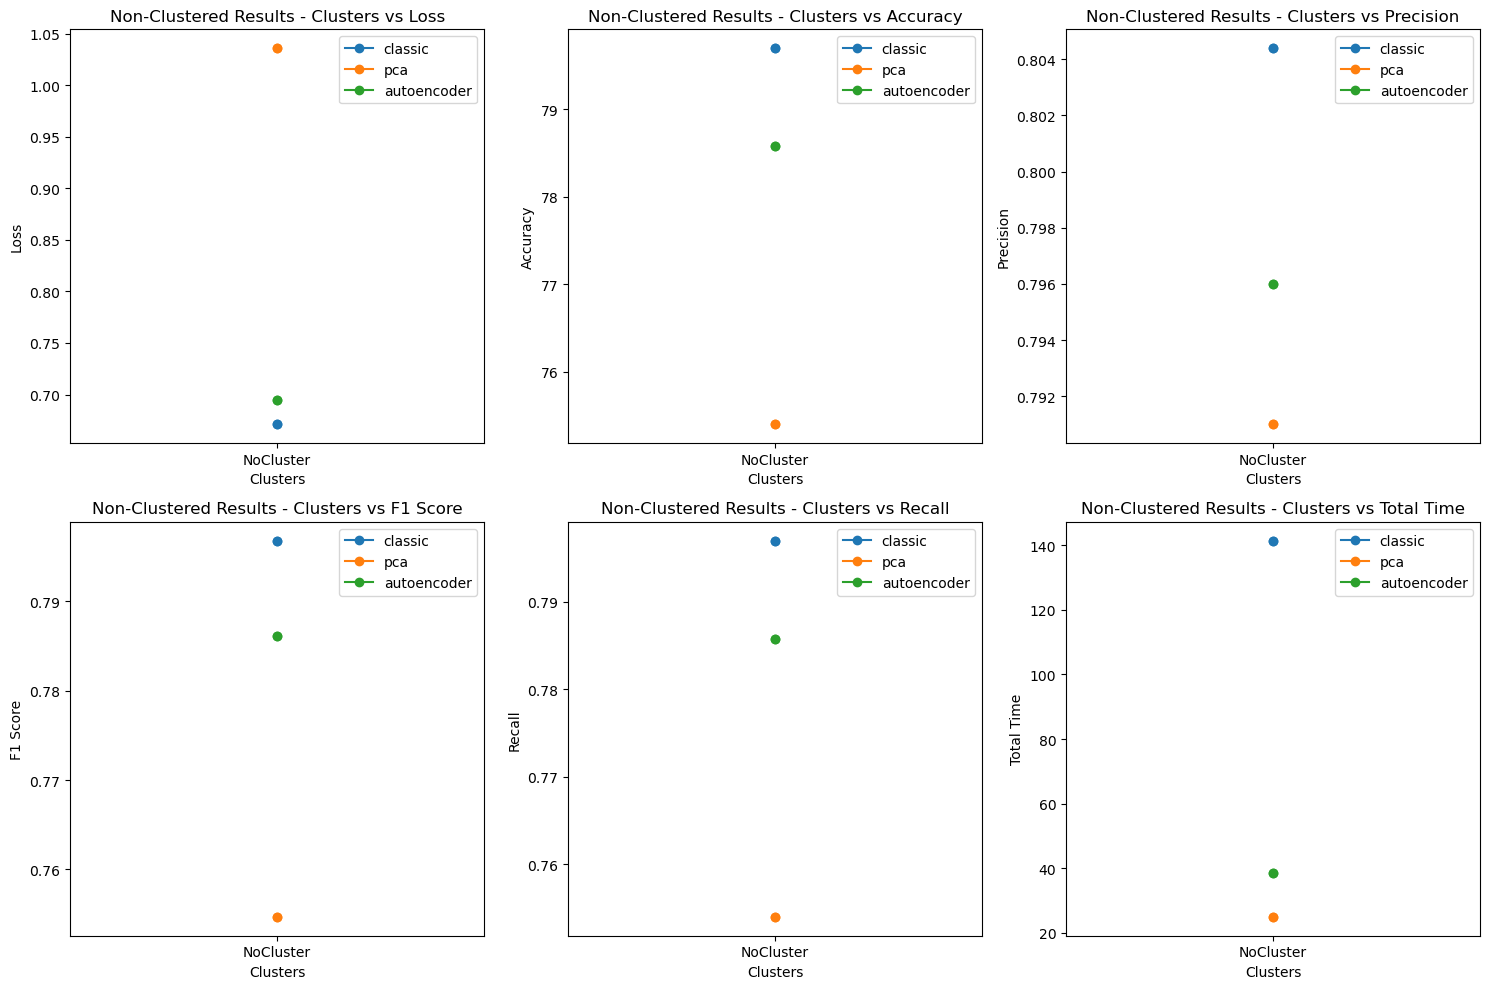


Clustered Results:
classic:
  Final Loss: {2: 0.9650899912834168, 4: 0.7791144682884217, 6: 0.7002888797283172, 8: 0.6341782252311706, 10: 0.6205932253837585}
  Final Accuracy: {2: 76.4, 4: 80.78, 6: 83.14, 8: 85.09, 10: 85.82}
  Final Precision: {2: 0.7928764484878046, 4: 0.8202367082430311, 6: 0.8393103040409434, 8: 0.854993799162264, 10: 0.8620199277359515}
  Final F1 Score: {2: 0.7617446365747026, 4: 0.8073585764897642, 6: 0.8319706260875552, 8: 0.8510890411779866, 10: 0.8581522653048962}
  Final Recall: {2: 0.764, 4: 0.8078000000000001, 6: 0.8314, 8: 0.8509, 10: 0.8582000000000001}
  Total Time: {2: 199.76087760925293, 4: 418.56348967552185, 6: 583.9885773658752, 8: 875.5205240249634, 10: 1123.4134290218353}
pca:
  Final Loss: {2: 0.9212159948348999, 4: 0.8340592746734619, 6: 0.8391960829734803, 8: 0.7794809635162353, 10: 0.7595254321098328}
  Final Accuracy: {2: 73.89, 4: 76.12, 6: 75.07, 8: 76.83, 10: 77.54}
  Final Precision: {2: 0.7762773416371462, 4: 0.7913754809007085, 6: 0

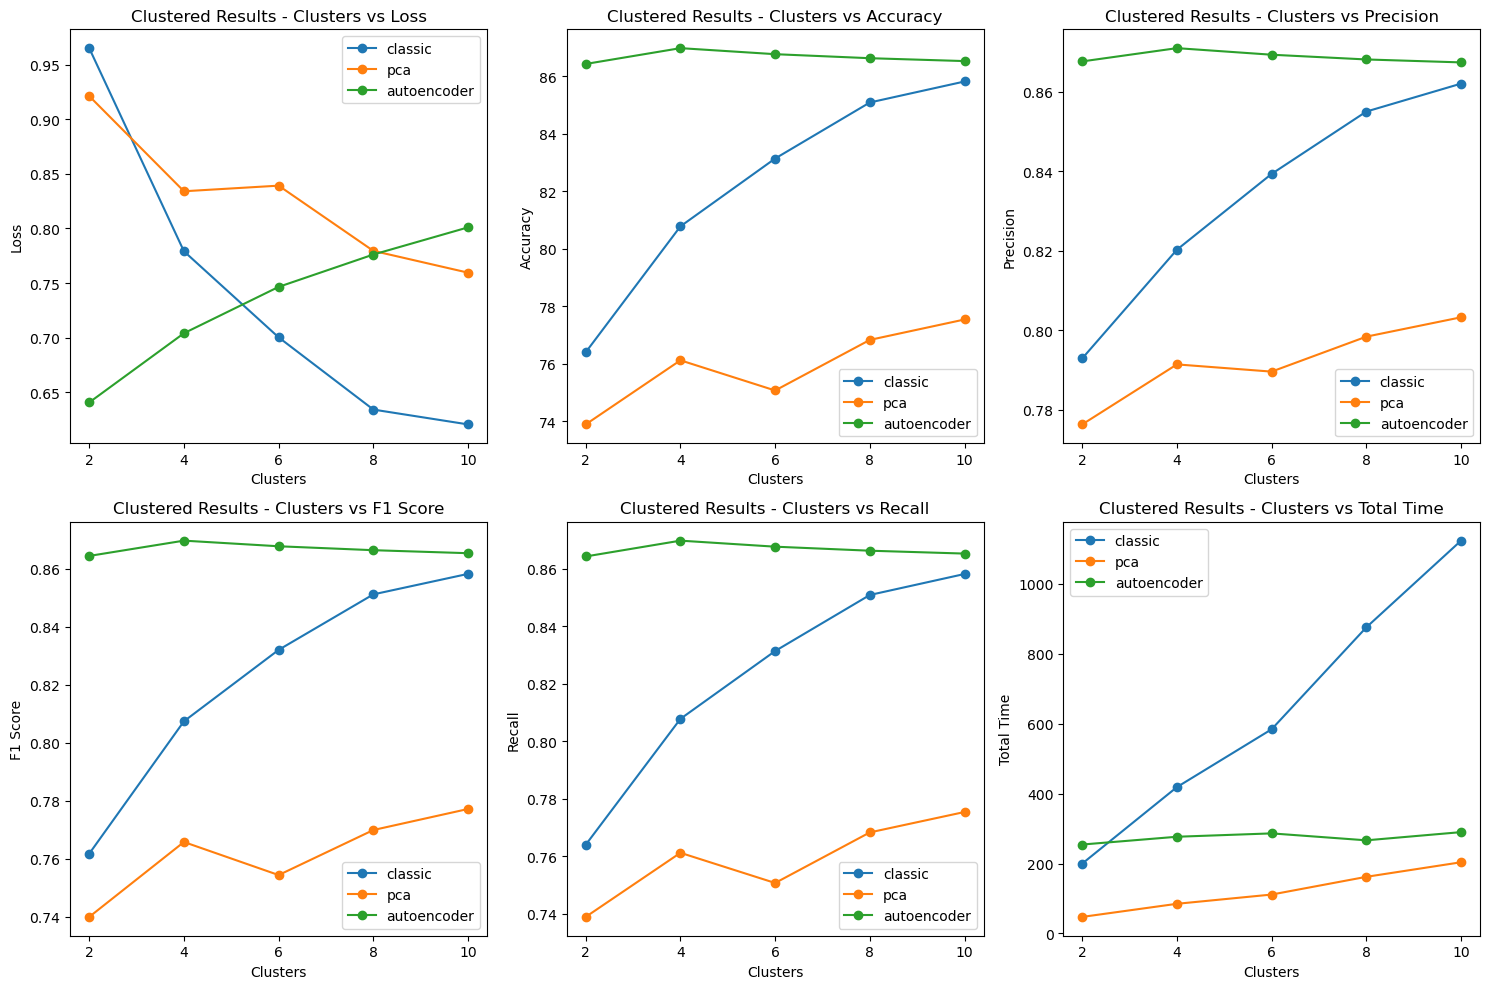

In [14]:
import numpy as np
import matplotlib.pyplot as plt

#TODO: we have to multiply time by 8 first

# Function to compute final metrics
def compute_final_metrics(metrics):
    final_loss = {alpha: data['losses'][-1] for alpha, data in metrics.items()}
    final_accuracy = {alpha: data['accuracy'][-1] for alpha, data in metrics.items()}
    final_precision = {alpha: data['precision'][-1] for alpha, data in metrics.items()}
    final_f1 = {alpha: data['f1'][-1] for alpha, data in metrics.items()}
    final_recall = {alpha: data['recall'][-1] for alpha, data in metrics.items()}

    # Sum of all training times
    total_time = {
        alpha: sum(data.get('TrainingTime', data.get('trainingTime', [0])))
        for alpha, data in metrics.items()
    }

    return final_loss, final_accuracy, final_precision, final_f1, final_recall, total_time

# Function to print results
def print_results(results, title):
    print(f"\n{title}:")
    for method in results.keys():
        final_loss, final_accuracy, final_precision, final_f1, final_recall, total_time = compute_final_metrics(results[method])
        print(f"{method}:")
        print("  Final Loss:", final_loss)
        print("  Final Accuracy:", final_accuracy)
        print("  Final Precision:", final_precision)
        print("  Final F1 Score:", final_f1)
        print("  Final Recall:", final_recall)
        print("  Total Time:", total_time)

# Function to plot the results
def plot_results(results, title, filename):
    plt.figure(figsize=(15, 10))

    # List of metrics to plot
    metrics_names = ["Loss", "Accuracy", "Precision", "F1 Score", "Recall", "Total Time"]
    for i, metric in enumerate(metrics_names):
        plt.subplot(2, 3, i + 1)

        # Plotting each method's metrics
        for method in results.keys():
            final_loss, final_accuracy, final_precision, final_f1, final_recall, total_time = compute_final_metrics(results[method])

            # Select the right metric based on the iteration
            metric_values = {
                "Loss": final_loss,
                "Accuracy": final_accuracy,
                "Precision": final_precision,
                "F1 Score": final_f1,
                "Recall": final_recall,
                "Total Time": total_time
            }[metric]

            # Plot the metric values for each method
            plt.plot(list(metric_values.keys()) + ['NoCluster'], list(metric_values.values()) + [metric_values.get('NoCluster', np.nan)], marker='o', label=method)

        plt.xlabel('Clusters')
        plt.ylabel(metric)
        plt.title(f'{title} - Clusters vs {metric}')
        plt.legend()

    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Assuming 'results' and 'clusteredResults' are the data for the methods
# Print and plot results for non-clustered and clustered data

print_results(results, "Non-Clustered Results")
plot_results(results, "Non-Clustered Results", "non_clustered_results.png")

print_results(clusteredResults, "Clustered Results")
plot_results(clusteredResults, "Clustered Results", "clustered_results.png")
